# Heat-exchanger data analysis and engineering calcs (Cristian Merli, UniTn id: 211384)

## Environment setup

### - General software info

* Useful links:

https://code.visualstudio.com/docs/datascience/data-science-tutorial

* SW header:

In [385]:
__author__ = "Cristian Merli"
__copyright__ = "Copyright 2021, The Cogent Project"
__credits__ = ["Cristian Merli", "Ing. Maurizio Grigiante"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Cristian Merli"
__email__ = "cristian.merli@studenti.unitn.it"
__status__ = "Draft"

### - Libraries import

* Import libraries and packages

In [386]:
import pandas as pd                                                                                     # Data-analysis panda lib
import numpy as np                                                                                      # Data-analysis numpy lib
import seaborn as sns                                                                                   # Seaborn plottin' lib
import matplotlib.pyplot as plt                                                                         # Math plottin' lib
import enum as en                                                                                       # Enum lib
from scipy.interpolate import interp1d                                                                  # 1D-interpolation lib
from scipy.optimize import curve_fit                                                                    # Curve-fitting lib

### - Personalized plottig style

* Plotting settings-vars

In [387]:
plt_style = "seaborn-dark"                                                                              # Plotting style
bkg_col = "#00071c"                                                                                     # Background color (hex)
grid_col = "#1c338a"                                                                                    # Grid color (hex)
text_col = "#e1e4ed"                                                                                    # Text color (hex)
leg_txt_col = "#ffffff"                                                                                 # Legend text color (hex)
plt_f1_col = "#00fff7"                                                                                  # F1 data trend color (hex)
plt_f2_col = "#ff8000"                                                                                  # F2 data trend color (hex)
plt_t1_col = "#ff1100"                                                                                  # T1 data trend color (hex)
plt_t2_col = "#0ac700"                                                                                  # T2 data trend color (hex)
plt_t3_col = "#f2ff00"                                                                                  # T3 data trend color (hex)
plt_t4_col = "#ff00f2"                                                                                  # T4 data trend color (hex)
tp_var_col = "#ff00e8"                                                                                  # Thermophysic variable trend color (hex)
tp_intp_var_col = "#ff7c00"                                                                             # Thermophysic variable interpolated trend color (hex)
dbs_c = "#0045c4"                                                                                       # Datablocks lines color (hex)
dbs_sel_c = "#4fbd37"                                                                                   # Selected datablocks lines color (hex)
dbs_sel_col = "#0cf700"                                                                                 # Selected datablocks fill color (hex)
inteval_box_col = "#ae00ff"                                                                             # Interval text-box color (hex)
plt_size_x = 26                                                                                         # Plotting X size
plt_size_y = 14                                                                                         # Plotting Y size
dbs_w = 3                                                                                               # Datablocks lines width
dbs_sel_w = 9                                                                                           # Selected datablocks lines width
dbs_sel_alpha = 0.15                                                                                    # Selected datablocks fill alpha
interval_txt_y_offs = 260                                                                               # Interval txt Y pos offset
sel_interval_txt_y_offs = -45                                                                           # Selected interval txt Y pos offset
interval_txt_size = 20                                                                                  # Interval text size
interval_box_alpha = 0.8                                                                                # Interval text-box alpha
plt_line = "--"                                                                                         # Plotting line type
plt_marker = 'o'                                                                                        # Plotting marker type

* Function definition to customize plotting style

In [388]:
def set_plt_style():                                                                                    # set_plt_style()
  plt.style.use(plt_style)                                                                              # Set defined plotting style
  for param in ["figure.facecolor", "axes.facecolor", "savefig.facecolor"]:                             # Chg bkg col
      plt.rcParams[param] = bkg_col                                                                     # Set col
  for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:                         # Chg bkg txt
      plt.rcParams[param] = text_col                                                                    # Set col
  plt.grid(color=grid_col)                                                                              # Set grid col
  leg = plt.legend()                                                                                    # Mod legend
  plt.setp(leg.get_texts(), color=leg_txt_col)                                                          # Set legend txt col

## Heat-exchanger data analysis

### - Dataset formatting and import

* Dataset file-vars: original (.dat) file and formatted (.csv) file

In [389]:
dat_data_filepath = "../dataset/scambiatore26112021_5.dat"                                              # Original dataset filepath (.dat)
csv_data_filepath = "../dataset/scambiatore26112021_5.csv"                                              # Formatted dataset filepath (generate new .csv file)

* Modification-vars to perform while converting and formatting (.dat) file into (.csv) file

In [390]:
old_sep_chr = '\t'                                                                                      # Sep chr in (.dat) file
csv_sep_chr = ';'                                                                                       # Sep chr in (.csv) file
comments_str = "% "                                                                                     # Delete comment-strings in (.dat) file when creatin' (.csv) file
oth_op_old_lbl = "Altra operazione"                                                                     # Replace 'other oper' lbl

* Heat-exchanger operation label-vars

In [391]:
oth_op_lbl = "Altra-operazione"                                                                         # Other oper lbl
cocurrent_flow_lbl = "Equicorrente"                                                                     # Cocurrent flow lbl
countercurrent_flow_lbl = "Controcorrente"                                                              # Countercurrent flow lbl

* Dataset columns vars

In [392]:
time_col = "Time(s)"                                                                                    # Time col in dataset (time ellapsed vals [s])
f1_col = "F1(l/h)"                                                                                      # Volume flow rate 1 col in dataset (cold fluid volume flow rate vals [l/h])
f2_col = "F2(l/h)"                                                                                      # Volume flow rate 2 col in dataset (hot fluid volume flow rate vals [l/h])
t1_col = "T1(degC)"                                                                                     # Temp 1 col in dataset (cold-in fluid temp vals [°C])
t2_col = "T2(degC)"                                                                                     # Temp 2 col in dataset (hot-in fluid temp vals [°C])
t3_col = "T3(degC)"                                                                                     # Temp 3 col in dataset (cold-out fluid temp vals [°C])
t4_col = "T4(degC)"                                                                                     # Temp 4 col in dataset (hot-out fluid temp vals [°C])
conf_col = "Configurazione"                                                                             # Config col in dataset

* Convert and format dataset: open and manipulate data in (.dat) file, writing formatted data inside (.csv) file

In [393]:
with open(dat_data_filepath,'r') as src_fl:                                                             # Open src file in read mode: (.dat) file
  with open(csv_data_filepath,'w') as dest_fl:                                                          # Open dest file in write mode: (.csv) file
      next(src_fl)                                                                                      # Skip header line in src file
      for line in src_fl:                                                                               # Read src file line-by-line
          line = line.replace(oth_op_old_lbl, oth_op_lbl)                                               # Replace target string (other operation label)
          line = line.replace(old_sep_chr, csv_sep_chr)                                                 # Replace data separator-chars
          line = line.replace(comments_str, '')                                                         # Delete target string (comment string in src file)
          dest_fl.write(line)                                                                           # Write each formatted data line inside dest file (.csv)

* Import dataset data from formatted (.csv) file, creating a 'DataFrame' variable

In [394]:
he_data = pd.read_csv(csv_data_filepath, sep=csv_sep_chr, encoding="utf8")                              # Import data from (.csv) dataset and create a new panda (lib) DataFrame variable: 'he_data'

### - Data plotting

* Plotting label-vars

In [395]:
plt_time_lbl = "Time [s]"                                                                               # X-axis lbl
plt_temp_flow_lbl = "Temperatures [°C]   /   Volume flow rates [l/h]"                                   # Y-axis lbl
plt_f1_lbl = "F1 - Cold fluid volume flow rate [l/h]"                                                   # Cold fluid vol flow rate (F1) lbl
plt_f2_lbl = "F2 - Hot fluid volume flow rate [l/h]"                                                    # Hot fluid vol flow rate (F2) lbl
plt_t1_lbl = "T1 - Cold-in fluid temperature [°C]"                                                      # Cold-in fluid temp (T1) lbl
plt_t2_lbl = "T2 - Hot-in fluid temperature [°C]"                                                       # Hot-in fluid temp (T2) lbl
plt_t3_lbl = "T3 - Cold-out fluid temperature [°C]"                                                     # Cold-out fluid temp (T3) lbl
plt_t4_lbl = "T4 - Hot-out fluid temperature [°C]"                                                      # Hot-out fluid temp (T4) lbl
interval_lbl = "MEASURE N. "                                                                            # Interval lbl
sel_interval_lbl = "SELECTED INTERVAL"                                                                  # Selected interval lbl

* Plotting-mode enum definition

In [396]:
class Plt_mode(en.Enum):                                                                                # Plottin' mode enum class
    complete = 1                                                                                        # Complete plotting mode
    detailed = 2                                                                                        # Detailed plotting mode

* Function definition to graphically plot data filtering operations

In [397]:
def plot_data_flt(db, call_str, start_idxs_dbs, end_idxs_dbs, min_stddevs_dbs_idx, mode):               # plot_data_flt(Datablock to split, Datablocks start idxs, Datablocks end idxs, Function call string, Ploting mode: complete/detailed)
  plt.title(call_str)                                                                                   # Plot title
  plt.xlabel(plt_time_lbl)                                                                              # X-axis lbl
  plt.ylabel(plt_temp_flow_lbl)                                                                         # Y-axis lbl
  sns.set(rc={"figure.figsize":(plt_size_x, plt_size_y)})                                               # Plottin' size
  sns.lineplot(x=time_col, y=f1_col, data=db, label=plt_f1_lbl, color=plt_f1_col)                       # Plot cold fluid vol flow rate (F1)
  sns.lineplot(x=time_col, y=f2_col, data=db, label=plt_f2_lbl, color=plt_f2_col)                       # Plot hot fluid vol flow rate (F2)
  sns.lineplot(x=time_col, y=t1_col, data=db, label=plt_t1_lbl, color=plt_t1_col)                       # Plot cold-in fluid temp (T1)
  sns.lineplot(x=time_col, y=t2_col, data=db, label=plt_t2_lbl, color=plt_t2_col)                       # Plot hot-in fluid temp (T2)
  sns.lineplot(x=time_col, y=t3_col, data=db, label=plt_t3_lbl, color=plt_t3_col)                       # Plot cold-out fluid temp (T3)
  sns.lineplot(x=time_col, y=t4_col, data=db, label=plt_t4_lbl, color=plt_t4_col)                       # Plot hot-out fluid temp (T4)
  if (mode == Plt_mode.detailed):                                                                       # In case of detailed plottin' mode selected
    plt.axvline(db[time_col].values[start_idxs_dbs[0]]-1, linewidth=dbs_w, color=dbs_c)                 # Plot first datablock-extra line
    for s_idx in start_idxs_dbs:                                                                        # Datablocks staring-lines plottin' cycle
      if (s_idx == start_idxs_dbs[min_stddevs_dbs_idx]):                                                # In case of selected datablock
        plt.axvline(db[time_col].values[s_idx], linewidth=dbs_sel_w, color=dbs_sel_c)                   # Plot selected datablock-line
      else:                                                                                             # Else in case of unselected datablocks
        plt.axvline(db[time_col].values[s_idx], linewidth=dbs_w, color=dbs_c)                           # Plot normal datablocks-lines
  idx = 0                                                                                               # Detailed plotting mode list scrolling index
  tgt_idx = 0                                                                                           # Detailed plotting mode list scrolling target index
  for e_idx in end_idxs_dbs:                                                                            # Datablocks ending-lines plottin' cycle
    if (mode == Plt_mode.detailed and e_idx == end_idxs_dbs[min_stddevs_dbs_idx]):                      # In case of selected datablock (and detailed plottin' mode selected)
      plt.axvline(db[time_col].values[e_idx-1], linewidth=dbs_sel_w, color=dbs_sel_c)                   # Plot selected datablock-line
      start_col = db[time_col].values[start_idxs_dbs[min_stddevs_dbs_idx]]                              # Define fill-color starting point
      end_col = db[time_col].values[end_idxs_dbs[min_stddevs_dbs_idx]-1]                                # Define fill-color ending point
      bottom, top = plt.ylim()                                                                          # Get Y-axis limit to calc interval text-box pos
      plt.axvspan(start_col, end_col, alpha=dbs_sel_alpha, color=dbs_sel_col)                           # Plot fill-color
      plt.text(int((start_col+end_col)/2), int(top/2)+sel_interval_txt_y_offs, sel_interval_lbl,
                fontsize=interval_txt_size, ha="center", va="center",
                bbox = dict(facecolor = inteval_box_col, alpha = interval_box_alpha))                   # Plot selected interval txt and box
    else:                                                                                               # Else in case of unselected datablocks
      plt.axvline(db[time_col].values[e_idx-1], linewidth=dbs_w, color=dbs_c)                           # Plot normal datablocks-lines
      if (mode == Plt_mode.complete and idx == tgt_idx and idx < len(end_idxs_dbs)-1):                  # Check fill-color plottin' cond
        start_col = db[time_col].values[end_idxs_dbs[idx]]                                              # Define fill-color starting point
        end_col = db[time_col].values[end_idxs_dbs[idx+1]-1]                                            # Define fill-color ending point
        bottom, top = plt.ylim()                                                                        # Get Y-axis limit to calc interval text-box pos
        plt.axvspan(start_col, end_col, alpha=dbs_sel_alpha, color=dbs_sel_col)                         # Plot fill-color
        plt.text(int((start_col+end_col)/2), int(top/2)+interval_txt_y_offs,
                 interval_lbl+str(int(idx/2)+1), fontsize=interval_txt_size, ha="center", va="center",
                 bbox = dict(facecolor = inteval_box_col, alpha = interval_box_alpha))                  # Plot interval txt and box
        tgt_idx += 2                                                                                    # Upd detailed plotting mode list scrolling target index
    idx += 1                                                                                            # Upd detailed plotting mode list scrolling index
  if (mode == Plt_mode.detailed):                                                                       # In case of detailed plottin' mode selected
    plt.axvline(db[time_col].values[e_idx-1]+1, linewidth=dbs_w, color=dbs_c)                           # Plot last datablock-extra line
  set_plt_style()                                                                                       # Function call to set personalized plotting style  
  plt.figure()                                                                                          # Plot figure

### - Data extraction and filtering

* Data intervals detection: extract data in different operating conditions

In [398]:
delim_idxs = [0] * 8                                                                                    # Delimiter-indexes array (array containing 8 dataframe row idxs - configurations start/end idxs)
arr_cell_ptr = 0                                                                                        # Delimiter-indexes array cells pointer (to access array cells vals)
rows_scroll_index = 0                                                                                   # Index to trace current row in dataframe rows scrolling cycle
old_oper_str = ""                                                                                       # Operation string in previous dataframe row
oper_str = ""                                                                                           # Operation string in current dataframe row

for rows_scroll_index, row in he_data.iterrows():                                                       # Cycle to scroll rows in dataframe, tracing row index
    old_oper_str = oper_str                                                                             # Update previous dataframe row string
    oper_str = row[conf_col]                                                                            # Update current dataframe row string
    if (rows_scroll_index > 1):                                                                         # Skip first row (previous and current dataframe row strings are initialized with the same val)
        if ((old_oper_str == oth_op_lbl) & (oper_str == cocurrent_flow_lbl)):                           # Cocurrent flow configuration start detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val
        if ((old_oper_str == cocurrent_flow_lbl) & (oper_str == oth_op_lbl)):                           # Cocurrent flow configuration end detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index (+1 for data split) in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val
        if ((old_oper_str == oth_op_lbl) & (oper_str == countercurrent_flow_lbl)):                      # Countercurrent flow configuration start detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val
        if ((old_oper_str == countercurrent_flow_lbl) & (oper_str == oth_op_lbl)):                      # Countercurrent flow configuration end detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index (+1 for data split) in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val
if (delim_idxs[7] == 0):                                                                                # In case last configuration lasts 'till dataframe tail row
    delim_idxs[7] = rows_scroll_index+1                                                                 # Set last configuration end idx as tail row idx inside delimiter-idxs array (+1 for data split)

he_data_cocurr1 = he_data[delim_idxs[0]:delim_idxs[1]]                                                  # Extract cocurrent measure 1 (btwn 1st and 2nd index in delimiter-indexes array)
he_data_countercurr1 = he_data[delim_idxs[2]:delim_idxs[3]]                                             # Extract countercurrent measure 1 (btwn 3rd and 4th index in delimiter-indexes array)
he_data_countercurr2 = he_data[delim_idxs[4]:delim_idxs[5]]                                             # Extract countercurrent measure 2 (btwn 5th and 6th index in delimiter-indexes array)
he_data_cocurr2 = he_data[delim_idxs[6]:delim_idxs[7]]                                                  # Extract cocurrent measure 2 (btwn 6th and 7th index in delimiter-indexes array)

* Data intervals cleaning: exclude eventual values with 'other-operation' label

In [399]:
he_data_cocurr1 = he_data_cocurr1[~he_data_cocurr1[conf_col].isin([oth_op_lbl])]                        # Remove eventual data corresponding to other-operation in heat-exchanger data cocurrent 1
he_data_countercurr1 = he_data_countercurr1[~he_data_countercurr1[conf_col].isin([oth_op_lbl])]         # Remove eventual data corresponding to other-operation in heat-exchanger data countercurrent 1
he_data_countercurr2 = he_data_countercurr2[~he_data_countercurr2[conf_col].isin([oth_op_lbl])]         # Remove eventual data corresponding to other-operation in heat-exchanger data countercurrent 1
he_data_cocurr2 = he_data_cocurr2[~he_data_cocurr2[conf_col].isin([oth_op_lbl])]                        # Remove eventual data corresponding to other-operation in heat-exchanger data cocurrent 2

* Plot data in DataFrame 'he_data' variable: temperatures and volume flow rates, taken during LabView data-acquisition on heat-exchanger

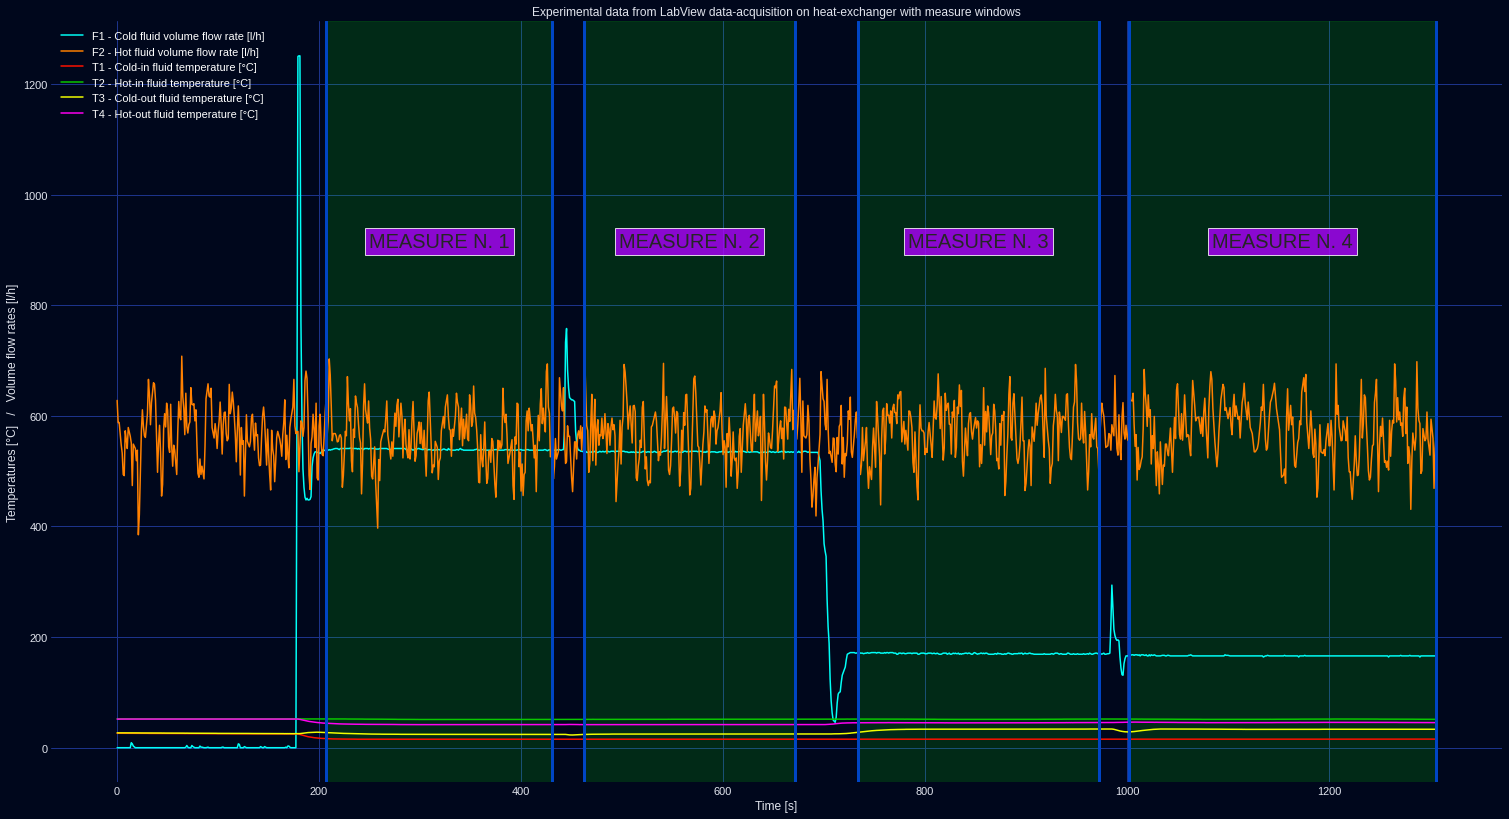

<Figure size 1872x1008 with 0 Axes>

In [400]:
plt_title = "Experimental data from LabView data-acquisition on heat-exchanger with measure windows"    # Plot title
plot_data_flt(he_data, plt_title, None, delim_idxs, None, Plt_mode.complete)                            # Function call to graphically plot data filtering operations (complete plottin' mode)

* Function definition to find min value index in vals list (non-zero idx)

In [401]:
def find_min_idx(vals):                                                                                 # find_min_idx(Vals list)
  min_idx = 0                                                                                           # Min val index init
  for i in range(len(vals)):                                                                            # Vals scrollin' cycle
    if (vals[i] < vals[min_idx]):                                                                       # Min val idx upd cond
      min_idx = i                                                                                       # Min val idx upd oper
  return min_idx                                                                                        # Rerturn min val idx in vals list (non-zero idx)

* Function definition to find optimal steady conditions data window, by calulating mean standard-deviations in datablocks and avoiding first transitory datablock

In [402]:
def find_stdy_cond(db, dbs_span, dbg_flg, call_str):                                                    # find_stdy_cond(Datablock to split, Datablocks span [samples], Debug flag, Function call string)
  if (dbg_flg):                                                                                         # If dbg flg is ena
    print("\n-------------------------------------------------------------")                            # Print dbg fbk
    print("--> NEW 'find_stdy_cond()' FUNCTION CALL FOR", call_str)                                     # Print dbg fbk
    print("-------------------------------------------------------------\n")                            # Print dbg fbk
  dbs = list()                                                                                          # Datablocks list
  stddevs_dbs = list()                                                                                  # Datablocks mean standard deviations list to detect the smallest one
  start_idxs_dbs = list()                                                                               # Datablocks starting-idxs (by datablocks span [samples])
  end_idxs_dbs = list()                                                                                 # Datablocks ending-idxs (by datablocks span [samples])
  num_datablocks = len(db) // dbs_span                                                                  # Datablocks list size (zero-idx)
  max_idx = db.index[-1]-db.index[0]                                                                    # Max datablock dataframe idx
  for i in range(num_datablocks, 0, -1):                                                                # Cycle to scroll datablocks backwards, excluding the first incomplete set (tail-transitory)
    start_idxs_dbs.append(max_idx-((i-1)*dbs_span)-dbs_span+1)                                          # Datablocks starting-idx (by datablocks span [samples])
    end_idxs_dbs.append(max_idx-((i-1)*dbs_span)+1)                                                     # Datablocks ending-idx (by datablocks span [samples])
    dbs.append(db[start_idxs_dbs[-1]:end_idxs_dbs[-1]])                                                 # Populate datablocks list
    f1_stddev = dbs[-1][f1_col].std()                                                                   # Calc f1 data standard-deviation
    f2_stddev = dbs[-1][f2_col].std()                                                                   # Calc f2 data standard-deviation
    t1_stddev = dbs[-1][t1_col].std()                                                                   # Calc t1 data standard-deviation
    t2_stddev = dbs[-1][t2_col].std()                                                                   # Calc t2 data standard-deviation
    t3_stddev = dbs[-1][t3_col].std()                                                                   # Calc t3 data standard-deviation
    t4_stddev = dbs[-1][t4_col].std()                                                                   # Calc t4 data standard-deviation
    stddevs_dbs.append((f1_stddev+f2_stddev+t1_stddev+t2_stddev+t3_stddev+t4_stddev) / 6)               # Calc the data mean standard deviations, to look for the best data window (steady cond)
    if (dbg_flg):                                                                                       # If dbg flg is ena
      print("f1_stddev: ", f1_stddev, "\nf2_stddev: ", f2_stddev, "\nt1_stddev: ", t1_stddev)           # Print dbg fbk
      print("t2_stddev: ", t2_stddev, "\nt3_stddev: ", t3_stddev, "\nt4_stddev: ", t4_stddev)           # Print dbg fbk
      print("mean_stddev: ", stddevs_dbs[-1], '\n')                                                     # Print dbg fbk
  min_stddevs_dbs_idx = find_min_idx(stddevs_dbs)                                                       # Function call to find min mean standard deviations in datablocks (non-zero idx)
  if (dbg_flg):                                                                                         # If dbg flg is ena
    print("min_stddevs_datablocks_idx: ", min_stddevs_dbs_idx)                                          # Print dbg fbk
  plot_data_flt(db, call_str, start_idxs_dbs, end_idxs_dbs, min_stddevs_dbs_idx, Plt_mode.detailed)     # Function call to graphically plot data filtering operations (detailed plottin' mode)
  return db[start_idxs_dbs[min_stddevs_dbs_idx]:end_idxs_dbs[min_stddevs_dbs_idx]]                      # Return datablock with best steady conditions

* Find data windows with optimal steady conditions, calling the previously defined functions

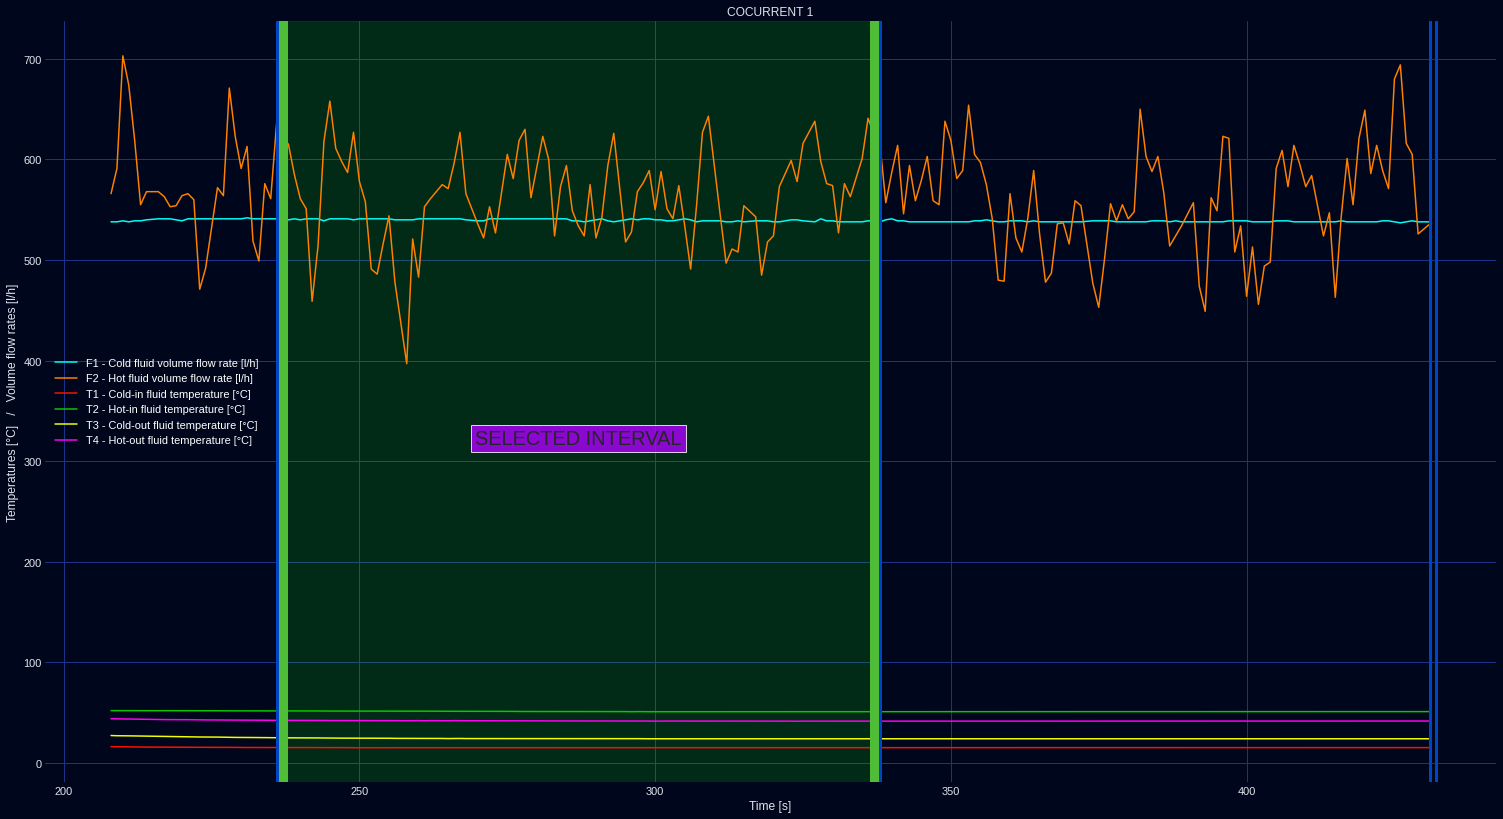

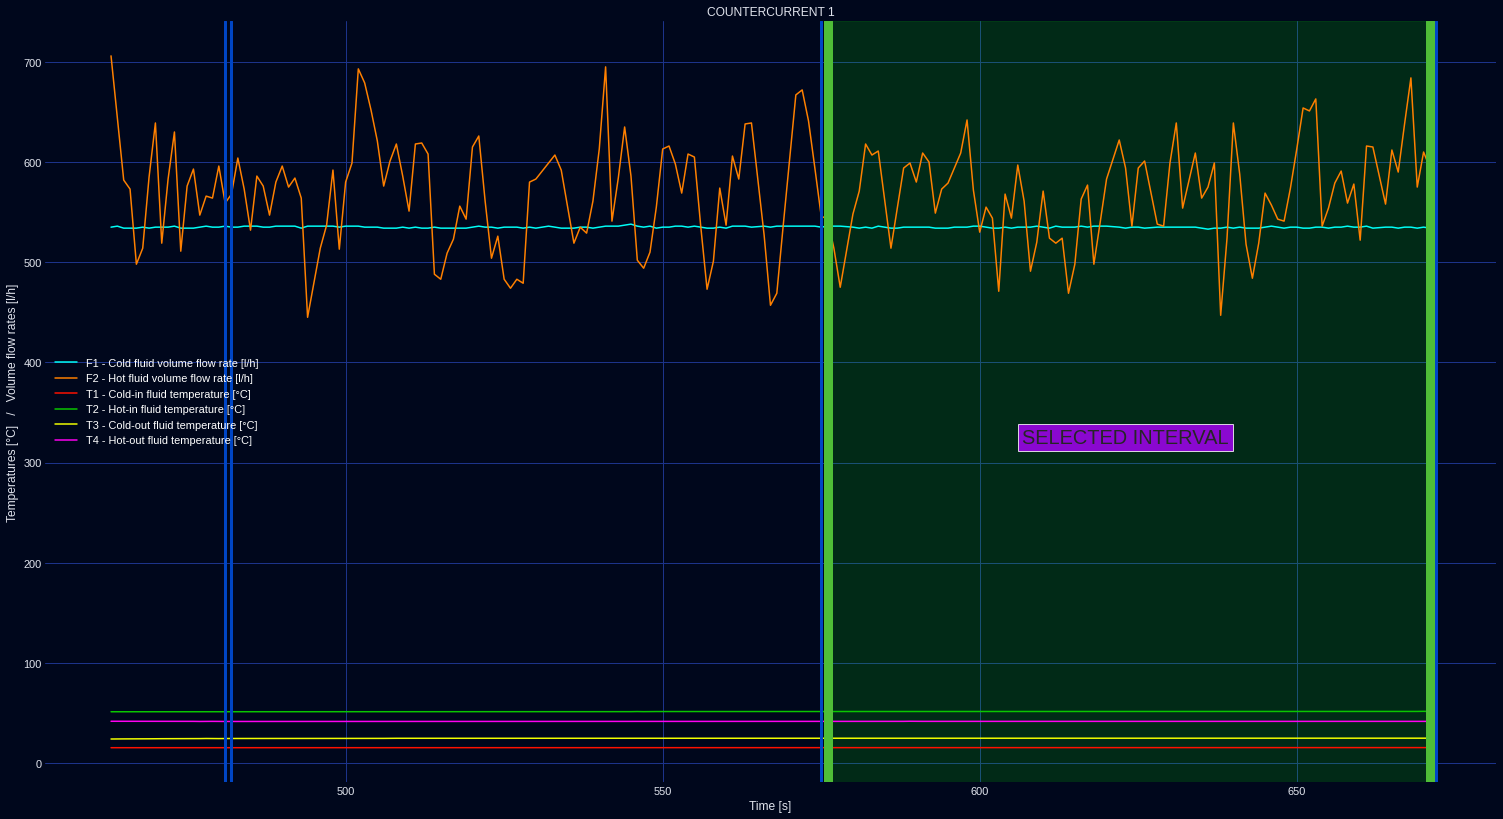

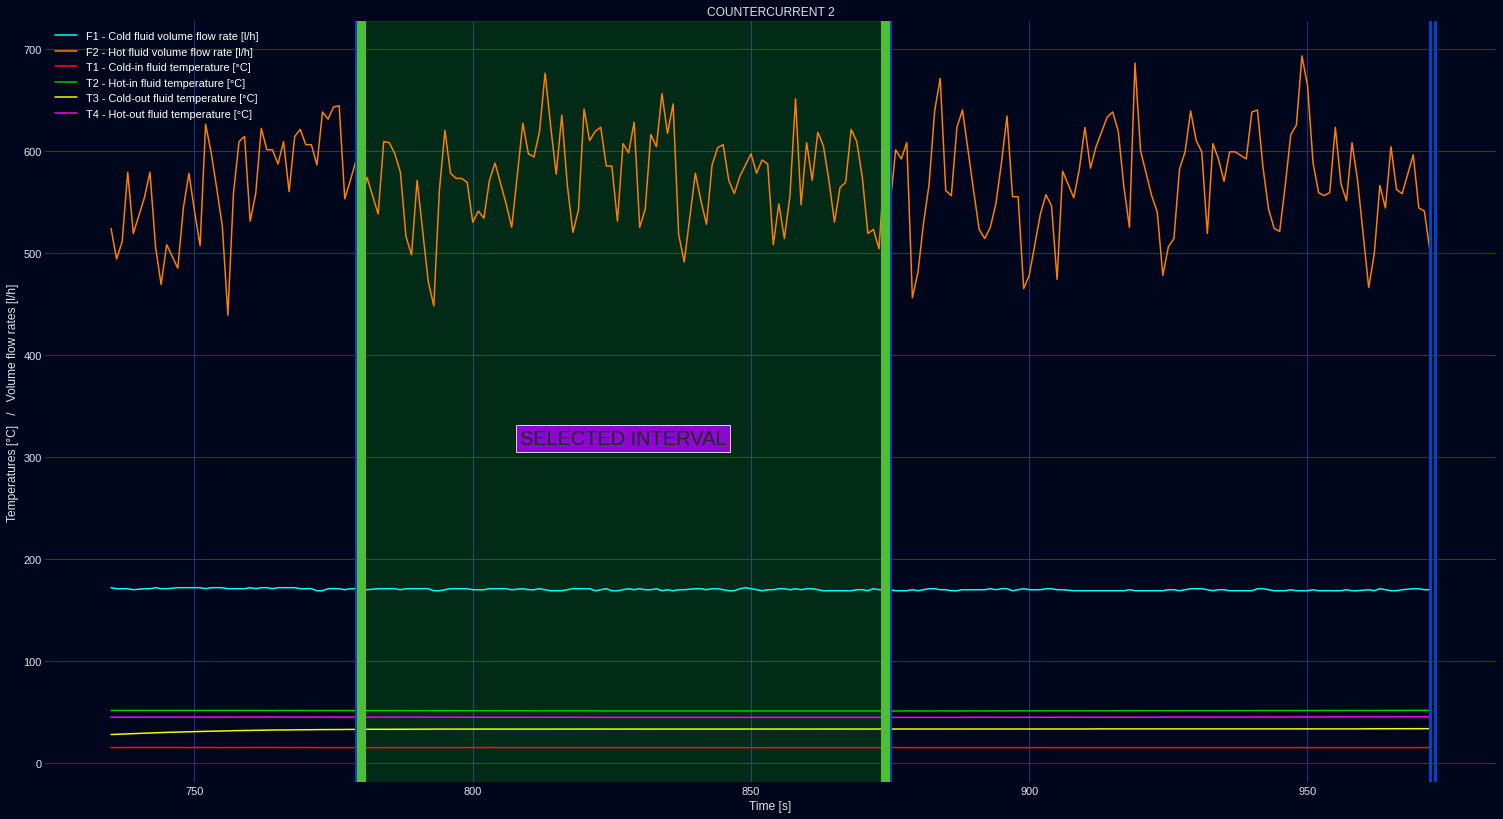

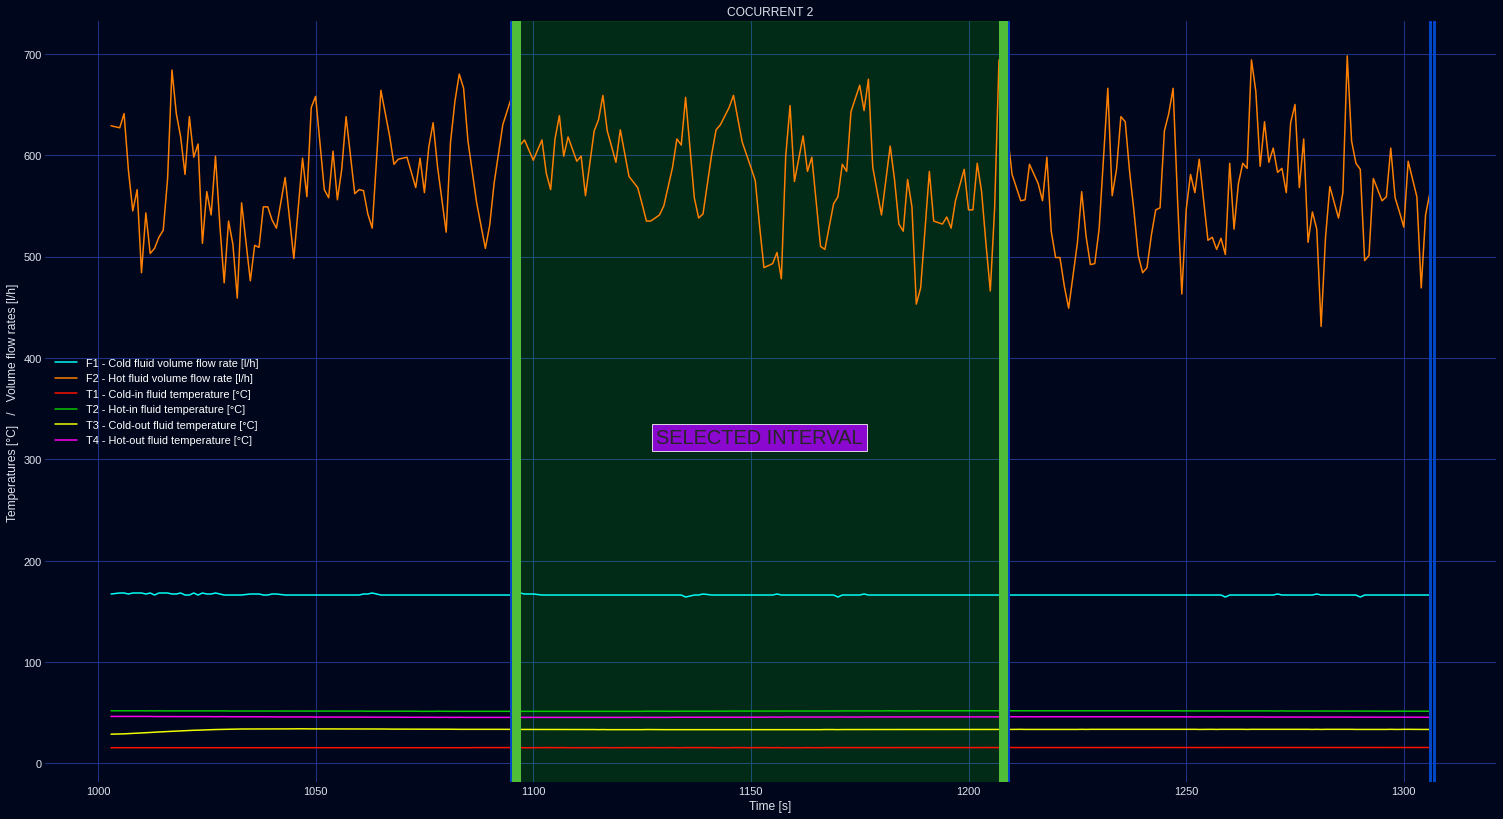

<Figure size 1872x1008 with 0 Axes>

In [403]:
sc_dbg_flg = False                                                                                      # Steady conditions debug flag (set to True in order to consult functions output)
sc_db_span = 90                                                                                         # Steady conditions datablocks span (in samples)

sc_win_cocurr1 = find_stdy_cond(he_data_cocurr1, sc_db_span, sc_dbg_flg, "COCURRENT 1")                 # Function call to find optimal steady conditions data window for cocurrent measure 1
sc_win_countercurr1 = find_stdy_cond(he_data_countercurr1, sc_db_span, sc_dbg_flg, "COUNTERCURRENT 1")  # Function call to find optimal steady conditions data window for countercurrent measure 1
sc_win_countercurr2 = find_stdy_cond(he_data_countercurr2, sc_db_span, sc_dbg_flg, "COUNTERCURRENT 2")  # Function call to find optimal steady conditions data window for countercurrent measure 2
sc_win_cocurr2 = find_stdy_cond(he_data_cocurr2, sc_db_span, sc_dbg_flg, "COCURRENT 2")                 # Function call to find optimal steady conditions data window for cocurrent measure 2

### - Measured variables definition

* Data-structure definition to contain measured variables values (temperatures and volume flow rates)

In [404]:
class Mean_vars_vals:                                                                                   # Mean vars values data-structure class
  f1: float                                                                                             # Mean F1 var value
  f2: float                                                                                             # Mean F2 var value
  t1: float                                                                                             # Mean T1 var value
  t2: float                                                                                             # Mean T2 var value
  t3: float                                                                                             # Mean T3 var value
  t4: float                                                                                             # Mean T4 var value

* Function definition to determine measured variables values (temperatures and volume flow rates)

In [405]:
def calc_meas_vars_vals(sc_db_win_interval):                                                            # calc_meas_vars_vals(Steady-conditions datablock window interval)
  m_vars_vals = Mean_vars_vals()                                                                        # Define new tmp mean vars values data-structure
  m_vars_vals.f1 = sc_db_win_interval[f1_col].mean()                                                    # Calc mean F1 var value in passed datablock and populate data-structure
  m_vars_vals.f2 = sc_db_win_interval[f2_col].mean()                                                    # Calc mean F2 var value in passed datablock and populate data-structure
  m_vars_vals.t1 = sc_db_win_interval[t1_col].mean()                                                    # Calc mean T1 var value in passed datablock and populate data-structure
  m_vars_vals.t2 = sc_db_win_interval[t2_col].mean()                                                    # Calc mean T2 var value in passed datablock and populate data-structure
  m_vars_vals.t3 = sc_db_win_interval[t3_col].mean()                                                    # Calc mean T3 var value in passed datablock and populate data-structure
  m_vars_vals.t4 = sc_db_win_interval[t4_col].mean()                                                    # Calc mean T4 var value in passed datablock and populate data-structure
  return m_vars_vals                                                                                    # Return mean vars values data-structure

* Determine measured variables values by calculating mean value in steady-conditions datablock window

In [406]:
mean_vals_dbg_flg = False                                                                               # Mean vals debug flag (set to True in order to consult output)

cocurr_meas1 = calc_meas_vars_vals(sc_win_cocurr1)                                                      # Determine measured variables values during 'measure 1' -> cocurrent1
countercurr_meas1 = calc_meas_vars_vals(sc_win_countercurr1)                                            # Determine measured variables values during 'measure 2' -> countercurrent1
countercurr_meas2 = calc_meas_vars_vals(sc_win_countercurr2)                                            # Determine measured variables values during 'measure 3' -> countercurrent2
cocurr_meas2 = calc_meas_vars_vals(sc_win_cocurr2)                                                      # Determine measured variables values during 'measure 4' -> cocurrent2

if (mean_vals_dbg_flg):                                                                                 # If dbg flg is ena
  print("\n--> Cocurrent measure 1 mean vals:")                                                         # Print dbg fbk
  print("F1[l/h]: "+str(cocurr_meas1.f1))                                                               # Print dbg fbk
  print("F2[l/h]: "+str(cocurr_meas1.f2))                                                               # Print dbg fbk
  print("T1[°C]: "+str(cocurr_meas1.t1))                                                                # Print dbg fbk
  print("T2[°C]: "+str(cocurr_meas1.t2))                                                                # Print dbg fbk
  print("T3[°C]: "+str(cocurr_meas1.t3))                                                                # Print dbg fbk
  print("T4[°C]: "+str(cocurr_meas1.t4))                                                                # Print dbg fbk
  print("\n--> Countercurrent measure 1 mean vals:")                                                    # Print dbg fbk
  print("F1[l/h]: "+str(countercurr_meas1.f1))                                                          # Print dbg fbk
  print("F2[l/h]: "+str(countercurr_meas1.f2))                                                          # Print dbg fbk
  print("T1[°C]: "+str(countercurr_meas1.t1))                                                           # Print dbg fbk
  print("T2[°C]: "+str(countercurr_meas1.t2))                                                           # Print dbg fbk
  print("T3[°C]: "+str(countercurr_meas1.t3))                                                           # Print dbg fbk
  print("T4[°C]: "+str(countercurr_meas1.t4))                                                           # Print dbg fbk
  print("\n--> Countercurrent measure 1 mean vals:")                                                    # Print dbg fbk
  print("F1[l/h]: "+str(countercurr_meas2.f1))                                                          # Print dbg fbk
  print("F2[l/h]: "+str(countercurr_meas2.f2))                                                          # Print dbg fbk
  print("T1[°C]: "+str(countercurr_meas2.t1))                                                           # Print dbg fbk
  print("T2[°C]: "+str(countercurr_meas2.t2))                                                           # Print dbg fbk
  print("T3[°C]: "+str(countercurr_meas2.t3))                                                           # Print dbg fbk
  print("T4[°C]: "+str(countercurr_meas2.t4))                                                           # Print dbg fbk
  print("\n--> Cocurrent measure 2 mean vals:")                                                         # Print dbg fbk
  print("F1[l/h]: "+str(cocurr_meas2.f1))                                                               # Print dbg fbk
  print("F2[l/h]: "+str(cocurr_meas2.f2))                                                               # Print dbg fbk
  print("T1[°C]: "+str(cocurr_meas2.t1))                                                                # Print dbg fbk
  print("T2[°C]: "+str(cocurr_meas2.t2))                                                                # Print dbg fbk
  print("T3[°C]: "+str(cocurr_meas2.t3))                                                                # Print dbg fbk
  print("T4[°C]: "+str(cocurr_meas2.t4))                                                                # Print dbg fbk

## Thermophysics variables

### - Datasets import

* Dataset-files vars: (.csv) table files

In [407]:
csv_air_atmp_filepath = "../dataset/air_atmp_thermo_vars.csv"                                           # Air at atm-pressure dataset filepath (.csv table file)
csv_water_filepath = "../dataset/water_thermo_vars.csv"                                                 # Water dataset filepath (.csv table file)

* Datasets columns vars

In [408]:
temp_col = "T(degC)"                                                                                    # Temp col in datasets (Temperature [°C])
rho_col = "Rho(kg/m3)"                                                                                  # Rho col in dataset (Density [kg/m^3])
cp_col = "Cp(kJ/kg*K)"                                                                                  # Cp col in dataset (Specific heat at constant pressure [kJ/(kg*K)])
lambda_col = "Lambda(W/m*K)"                                                                            # Lambda col in dataset (Thermal conductivity [W/(m*K)])
ni_col = "Ni(m2/s)"                                                                                     # Ni col in dataset (Kinematic viscosity [m^2/s])
beta_col = "Beta(1/K)"                                                                                  # Beta col in dataset (Thermodynamic beta (Coldness) [1/K])
pr_col = "Pr(-)"                                                                                        # Pr col in dataset (Prandtl number [adimensional])

* Import datasets data from (.csv) table files, creating 'DataFrames' variables

In [409]:
air_atmp = pd.read_csv(csv_air_atmp_filepath, sep=csv_sep_chr, encoding="utf8")                         # Import data from (.csv) dataset and create a new panda (lib) DataFrame variable: 'air_atmp'
water = pd.read_csv(csv_water_filepath, sep=csv_sep_chr, encoding="utf8")                               # Import data from (.csv) dataset and create a new panda (lib) DataFrame variable: 'water'

### - Data plotting

* Plotting label-vars

In [410]:
plt_temp_lbl = "Temperature - T [°C]"                                                                   # X-axis lbl: temperature
plt_rho_lbl = "Density - Rho [kg/m^3]"                                                                  # Y-axis lbl: thermophysics variable
plt_cp_lbl = "Specific heat at constant pressure - Cp [kJ/(kg*K)]"                                      # Y-axis lbl: thermophysics variable
plt_lambda_lbl = "Thermal conductivity - Lambda [W/(m*K)]"                                              # Y-axis lbl: thermophysics variable
plt_ni_lbl = "Kinematic viscosity - Ni [m^2/s]"                                                         # Y-axis lbl: thermophysics variable
plt_beta_lbl = "Thermodynamic beta (Coldness) - Beta [1/K]"                                             # Y-axis lbl: thermophysics variable
plt_pr_lbl = "Prandtl number - Pr [-]"                                                                  # Y-axis lbl: thermophysics variable
plt_title_sep = " / "                                                                                   # Title separator in str concat
plt_intp_temp_lbl = "Interpolated temperature - T [°C]"                                                 # X-axis lbl: interpolated temperature
plt_intp_rho_lbl = "Interpolated  density - Rho [kg/m^3]"                                               # Y-axis lbl: interpolated thermophysics variable
plt_intp_cp_lbl = "Interpolated specific heat at constant pressure - Cp [kJ/(kg*K)]"                    # Y-axis lbl: interpolated thermophysics variable
plt_intp_lambda_lbl = "Interpolated thermal conductivity - Lambda [W/(m*K)]"                            # Y-axis lbl: interpolated thermophysics variable
plt_intp_ni_lbl = "Interpolated kinematic viscosity - Ni [m^2/s]"                                       # Y-axis lbl: interpolated thermophysics variable
plt_intp_beta_lbl = "Interpolated thermodynamic beta (Coldness) - Beta [1/K]"                           # Y-axis lbl: interpolated thermophysics variable
plt_intp_pr_lbl = "Interpolated Prandtl number - Pr [-]"                                                # Y-axis lbl: interpolated thermophysics variable

* Function definition to graphically plot thermophysics variables interpolation

In [411]:
def plot_tp_vars(x_arr, y_arr, f_intp, intp_pts, x_lbl, y_lbl, y_intp_lbl, call_str):                   # plot_tp_vars(X-array, Y-array, Interpolation function, Number of interpolation points to plot, X-label, Y-label, Y_interp-label, Function call string)
  plt.title(call_str)                                                                                   # Plot title
  plt.xlabel(x_lbl)                                                                                     # X-axis lbl
  plt.ylabel(y_lbl)                                                                                     # Y-axis lbl
  sns.set(rc={"figure.figsize":(plt_size_x, plt_size_y)})                                               # Plottin' size
  sns.lineplot(x=x_arr, y=y_arr, label=y_lbl, marker=plt_marker, linestyle=plt_line, color=tp_var_col)  # Plot thermophysic variable data
  x_inpt_arr = np.linspace(x_arr[0], x_arr[-1], intp_pts)                                               # Generate interpolation X-array
  y_intp_arr = f_intp(x_inpt_arr)                                                                       # Generate interpolation Y-array
  sns.lineplot(x=x_inpt_arr, y=y_intp_arr, label=y_intp_lbl, color=tp_intp_var_col)                     # Plot thermophysic variable interpolated data
  set_plt_style()                                                                                       # Function call to set personalized plotting style
  plt.figure()                                                                                          # Plot figure

### - Air thermophysics variables interpolation at atm pressure

* Extract air interpolation temperatures (at atm pressure) from dataset and define the number of interpolation points to plot

In [412]:
air_atmp_temp = np.array(air_atmp[temp_col])                                                            # Temperatures array for air thermophysics variables at atm pressure
air_atmp_intp_typ = "cubic"                                                                             # Air thermophysics variables at atm pressure interpolation type
air_atmp_intp_pts = 1000                                                                                # Air thermophysics variables at atm pressure number of interpolation plotting points

* Function definition to apply air density interpolation (at atm pressure)

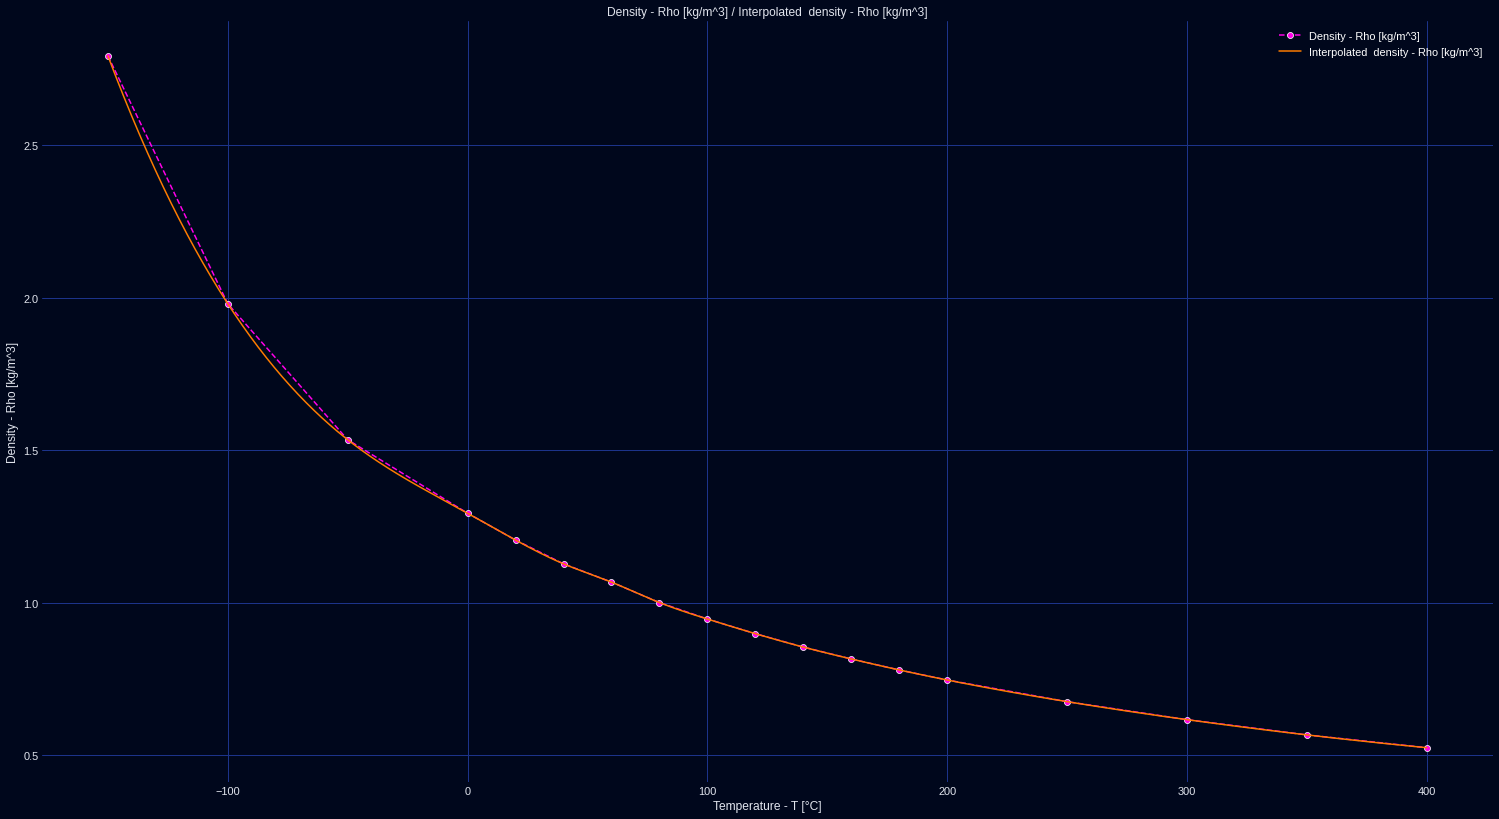

<Figure size 1872x1008 with 0 Axes>

In [413]:
air_atmp_rho = np.array(air_atmp[rho_col])                                                              # Air density array (thermophysic variable at atm pressure vs temp)
f_air_atmp_rho = interp1d(air_atmp_temp, air_atmp_rho, kind=air_atmp_intp_typ)                          # Air density interpolation function (thermophysic variable at atm pressure vs temp)

plot_tp_vars(air_atmp_temp, air_atmp_rho, f_air_atmp_rho, air_atmp_intp_pts,
             plt_temp_lbl, plt_rho_lbl, plt_intp_rho_lbl, plt_rho_lbl+plt_title_sep+plt_intp_rho_lbl)   # Function call to plot air density and interpolation (thermophysic variable at atm pressure vs temp)

* Function definition to apply air specific heat at constant pressure interpolation (at atm pressure)

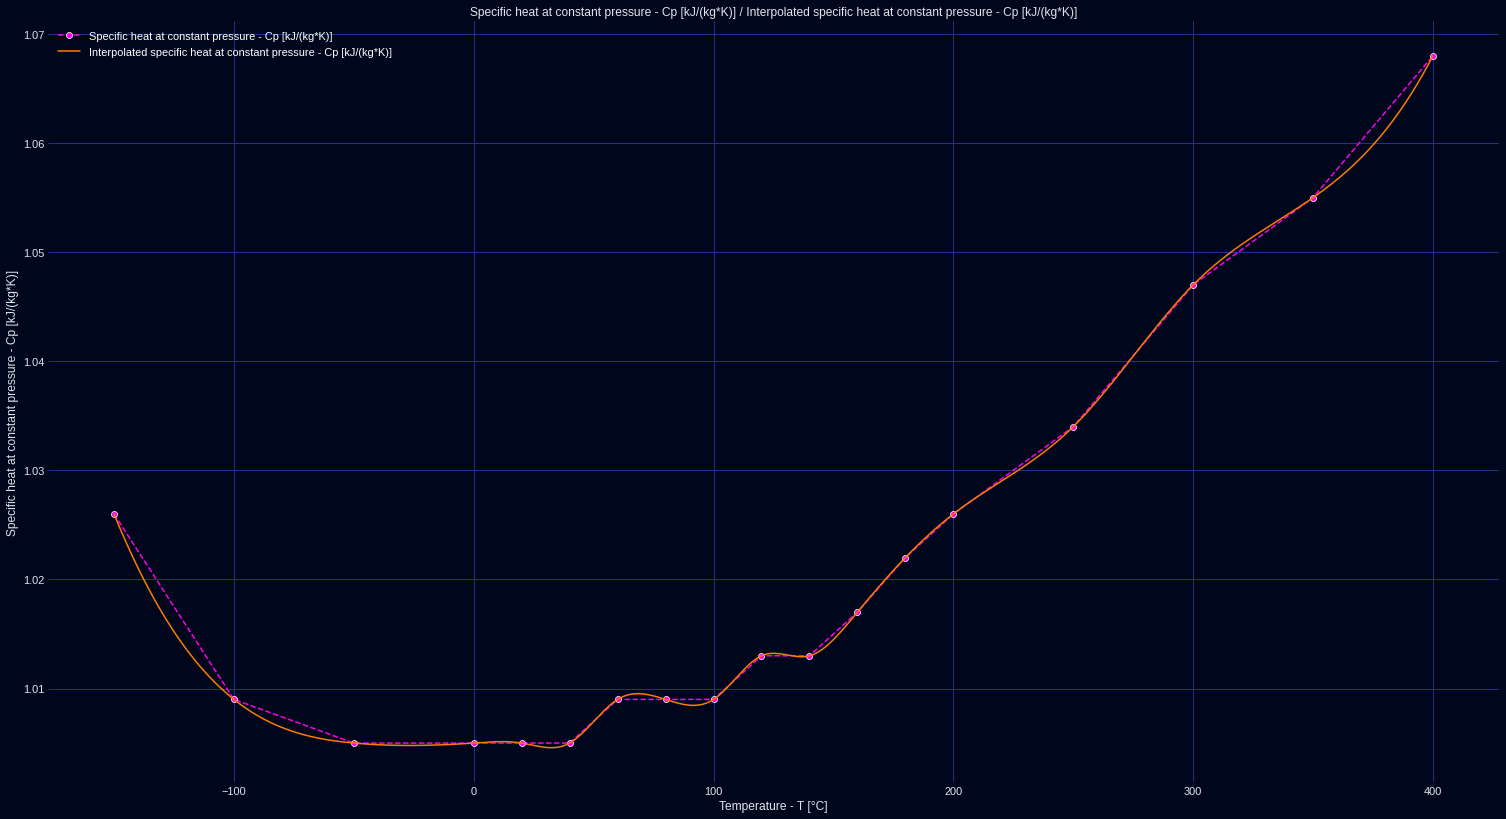

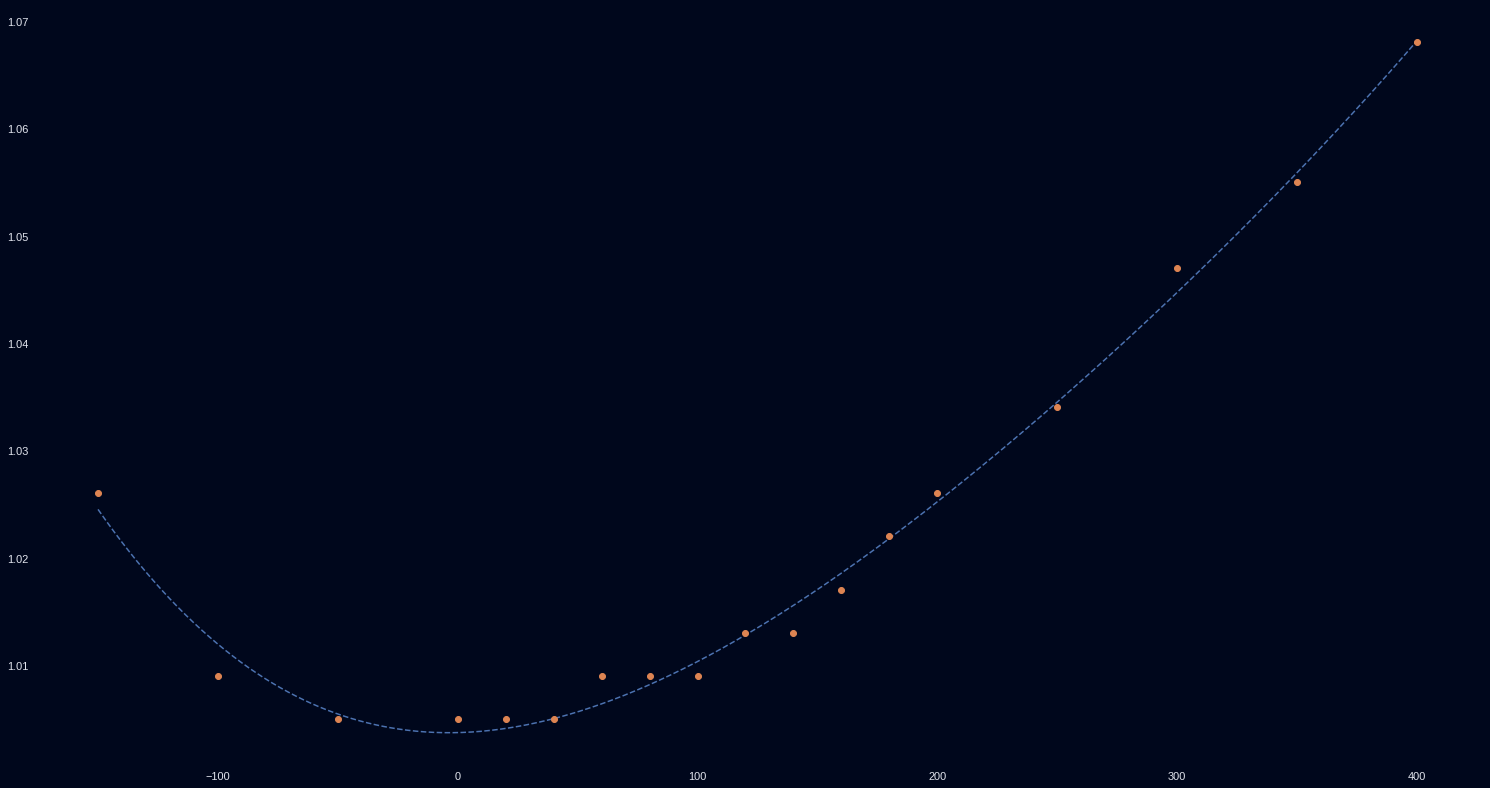

In [450]:
air_atmp_cp = np.array(air_atmp[cp_col])                                                                # Air specific heat at constant pressure array (thermophysic variable at atm pressure vs temp)
f_air_atmp_cp = interp1d(air_atmp_temp, air_atmp_cp, kind=air_atmp_intp_typ)                            # Air specific heat at constant pressure interpolation function (thermophysic variable at atm pressure vs temp)

plot_tp_vars(air_atmp_temp, air_atmp_cp, f_air_atmp_cp, air_atmp_intp_pts,
             plt_temp_lbl, plt_cp_lbl, plt_intp_cp_lbl, plt_cp_lbl+plt_title_sep+plt_intp_cp_lbl)       # Function call to plot air specific heat at constant pressure and interpolation (thermophysic variable at atm pressure vs temp)

p = np.polyfit(air_atmp_temp, air_atmp_cp, 4)
xx = np.linspace(-150, 400, 1000)
yy = np.polyval(p, xx)
plt.plot(xx, yy, "--") 
plt.plot(air_atmp_temp, air_atmp_cp, 'o') 

* Function definition to apply air thermal conductivity interpolation (at atm pressure)

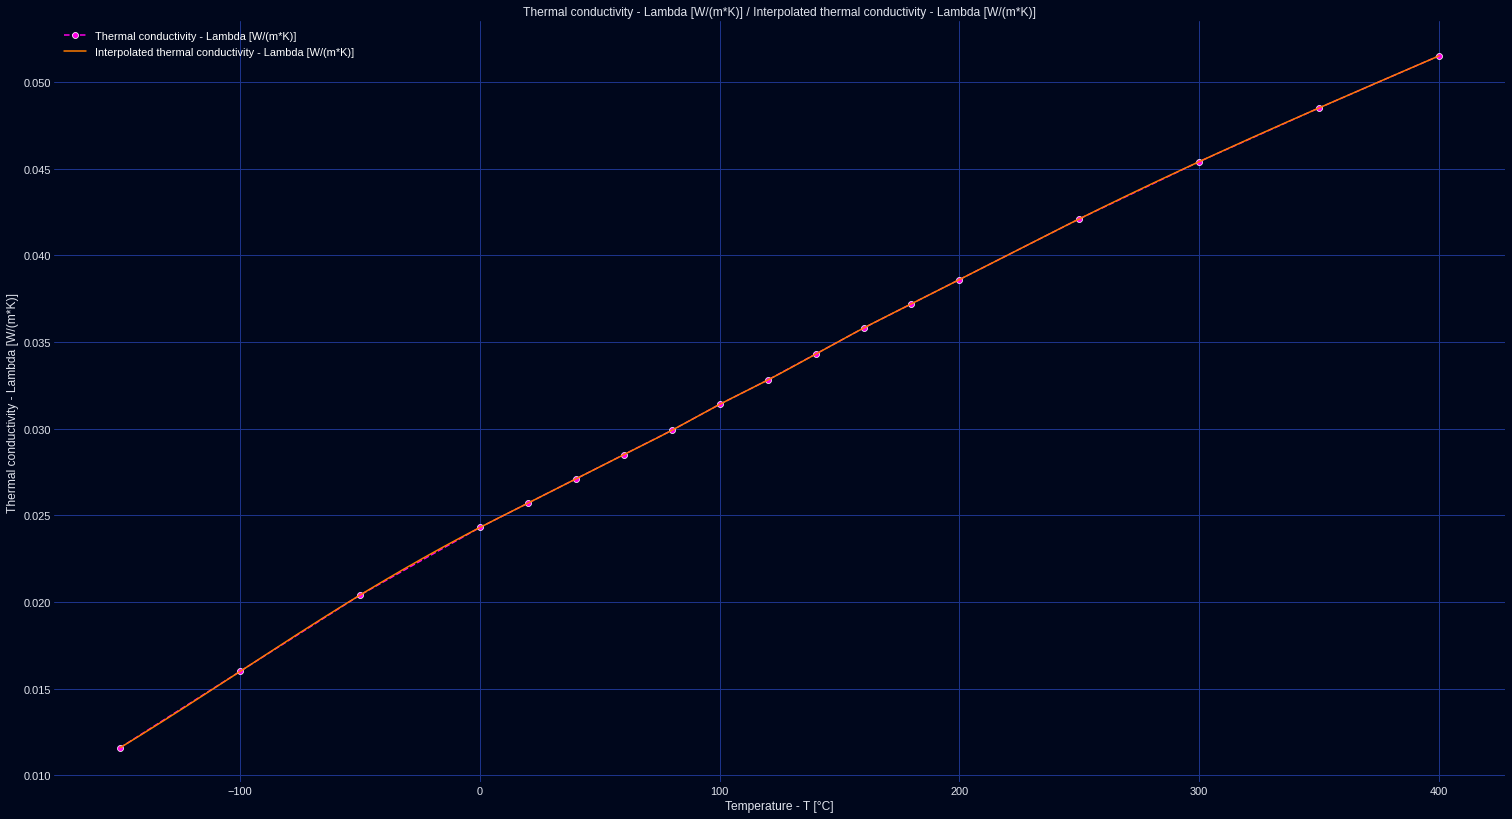

<Figure size 1872x1008 with 0 Axes>

In [415]:
air_atmp_lambda = np.array(air_atmp[lambda_col])                                                        # Air thermal conductivity array (thermophysic variable at atm pressure vs temp)
f_air_atmp_lambda = interp1d(air_atmp_temp, air_atmp_lambda, kind=air_atmp_intp_typ)                    # Air thermal conductivity interpolation function (thermophysic variable at atm pressure vs temp)

plot_tp_vars(air_atmp_temp, air_atmp_lambda, f_air_atmp_lambda, air_atmp_intp_pts, plt_temp_lbl,
             plt_lambda_lbl, plt_intp_lambda_lbl, plt_lambda_lbl+plt_title_sep+plt_intp_lambda_lbl)     # Function call to plot air thermal conductivity and interpolation (thermophysic variable at atm pressure vs temp)

* Function definition to apply air kinematic viscosity interpolation (at atm pressure)

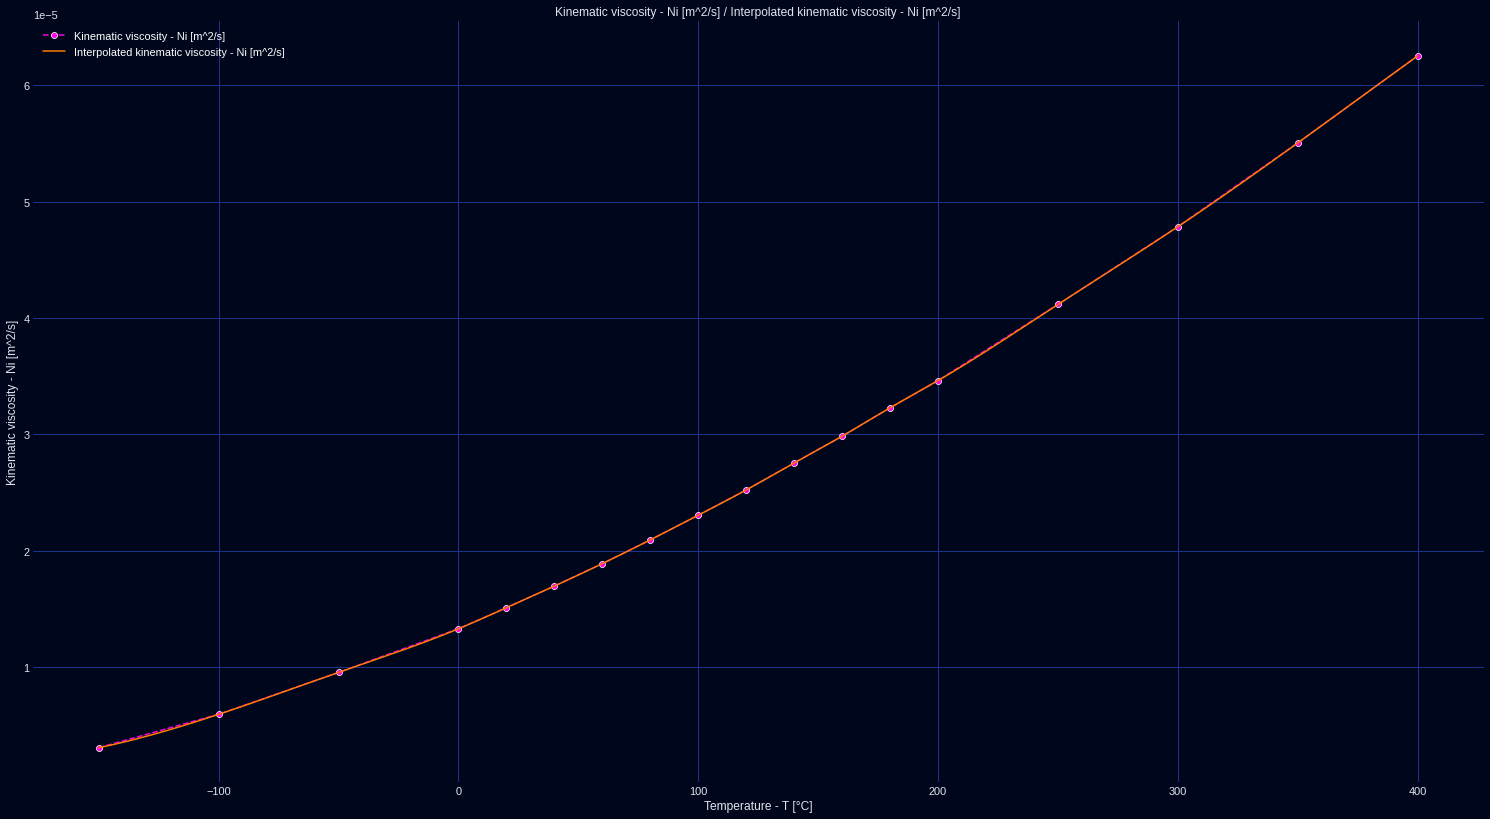

<Figure size 1872x1008 with 0 Axes>

In [416]:
air_atmp_ni = np.array(air_atmp[ni_col])                                                                # Air kinematic viscosity array (thermophysic variable at atm pressure vs temp)
f_air_atmp_ni = interp1d(air_atmp_temp, air_atmp_ni, kind=air_atmp_intp_typ)                            # Air kinematic viscosity interpolation function (thermophysic variable at atm pressure vs temp)

plot_tp_vars(air_atmp_temp, air_atmp_ni, f_air_atmp_ni, air_atmp_intp_pts,
             plt_temp_lbl, plt_ni_lbl, plt_intp_ni_lbl, plt_ni_lbl+plt_title_sep+plt_intp_ni_lbl)       # Function call to plot air kinematic viscosity and interpolation (thermophysic variable at atm pressure vs temp)

* Function definition to apply air thermodynamic beta (Coldness) interpolation (at atm pressure)

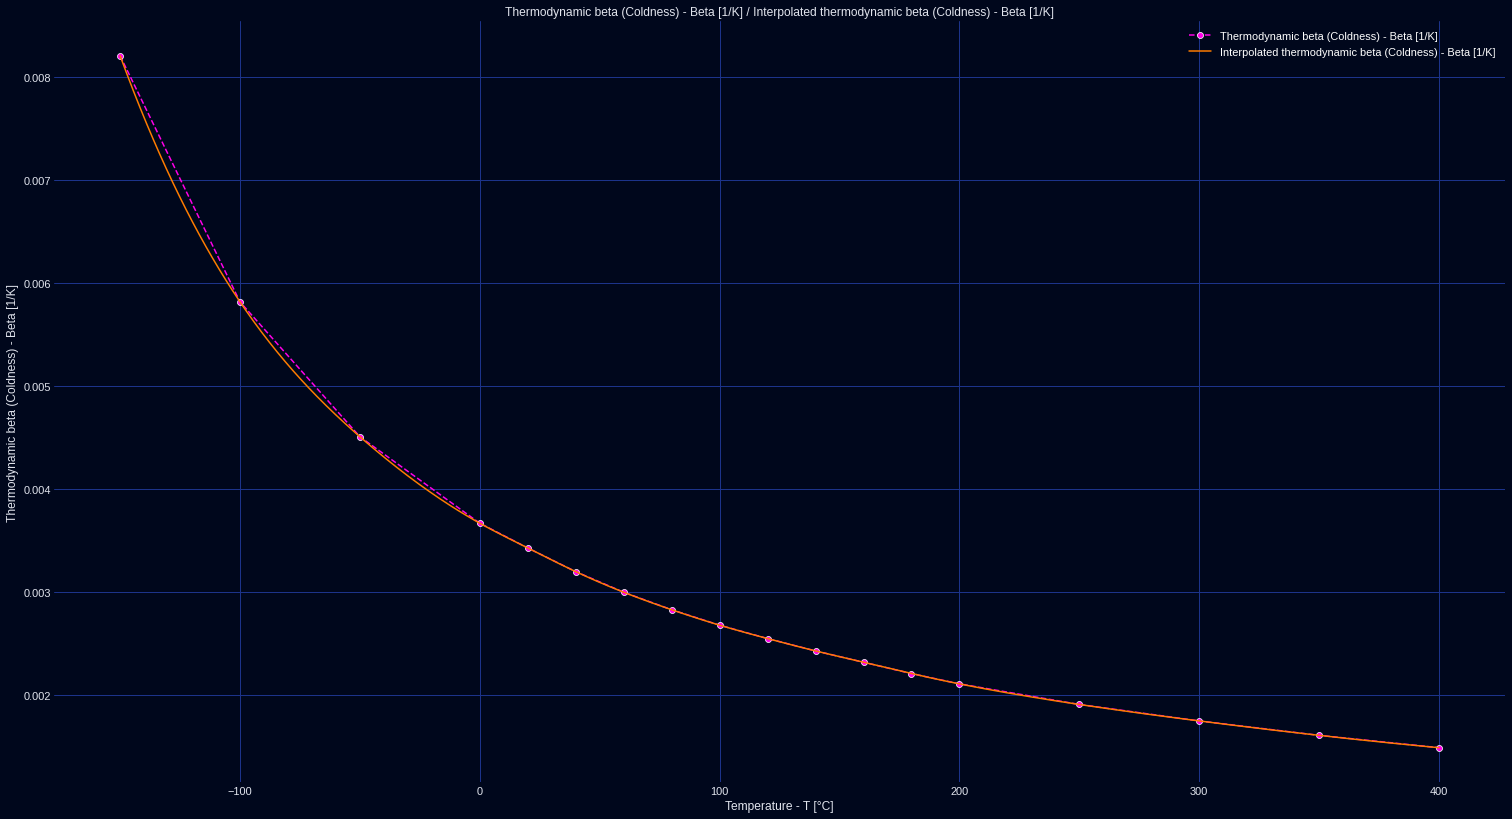

<Figure size 1872x1008 with 0 Axes>

In [417]:
air_atmp_beta = np.array(air_atmp[beta_col])                                                            # Air thermodynamic beta (Coldness) array (thermophysic variable at atm pressure vs temp)
f_air_atmp_beta = interp1d(air_atmp_temp, air_atmp_beta, kind=air_atmp_intp_typ)                        # Air thermodynamic beta (Coldness) interpolation function (thermophysic variable at atm pressure vs temp)

plot_tp_vars(air_atmp_temp, air_atmp_beta, f_air_atmp_beta, air_atmp_intp_pts, plt_temp_lbl,
             plt_beta_lbl, plt_intp_beta_lbl, plt_beta_lbl+plt_title_sep+plt_intp_beta_lbl)             # Function call to plot air thermodynamic beta (Coldness) and interpolation (thermophysic variable at atm pressure vs temp)

* Function definition to apply air Prandtl number interpolation (at atm pressure)

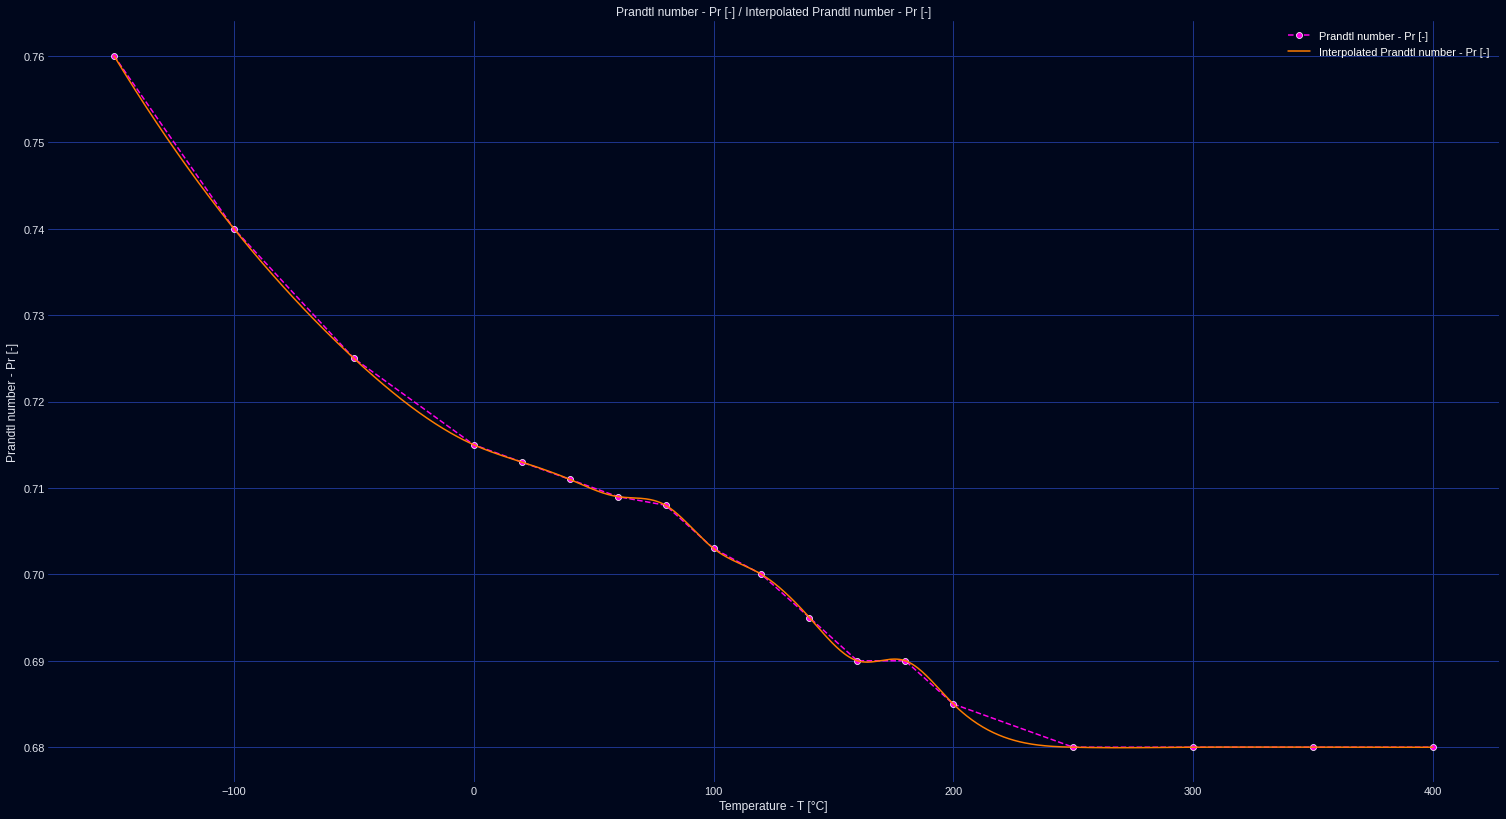

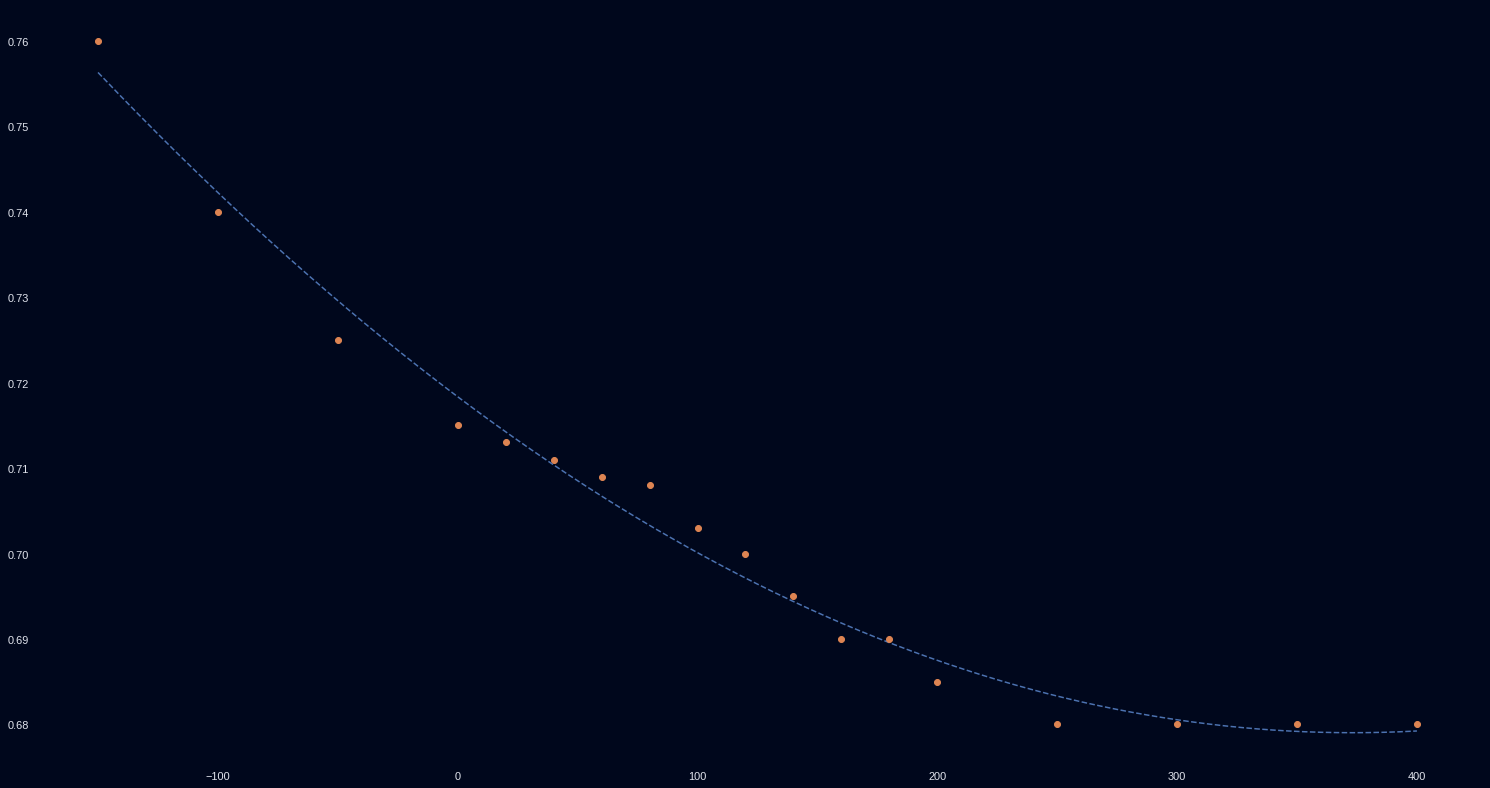

In [444]:
air_atmp_pr = np.array(air_atmp[pr_col])                                                                # Air Prandtl number array (thermophysic variable at atm pressure vs temp)
f_air_atmp_pr = interp1d(air_atmp_temp, air_atmp_pr, kind=air_atmp_intp_typ)                            # Air Prandtl number interpolation function (thermophysic variable at atm pressure vs temp)

plot_tp_vars(air_atmp_temp, air_atmp_pr, f_air_atmp_pr, air_atmp_intp_pts,
             plt_temp_lbl, plt_pr_lbl, plt_intp_pr_lbl, plt_pr_lbl+plt_title_sep+plt_intp_pr_lbl)       # Function call to plot air Prandtl number and interpolation (thermophysic variable at atm pressure vs temp)

p = np.polyfit(air_atmp_temp, air_atmp_pr, 2)
xx = np.linspace(-150, 400, 1000)
yy = np.polyval(p, xx)
plt.plot(xx, yy, "--")
plt.plot(air_atmp_temp, air_atmp_pr, 'o')

### - Water thermophysics variables interpolation

* Extract water interpolation temperatures from dataset and define the number of interpolation points to plot

In [419]:
water_temp = np.array(water[temp_col])                                                                  # Temperatures array for water thermophysics variables
water_intp_typ = "cubic"                                                                                # Water thermophysics variables interpolation type
water_intp_pts = 1000                                                                                   # Water thermophysics variables number of interpolation plotting points

* Function definition to apply water density interpolation

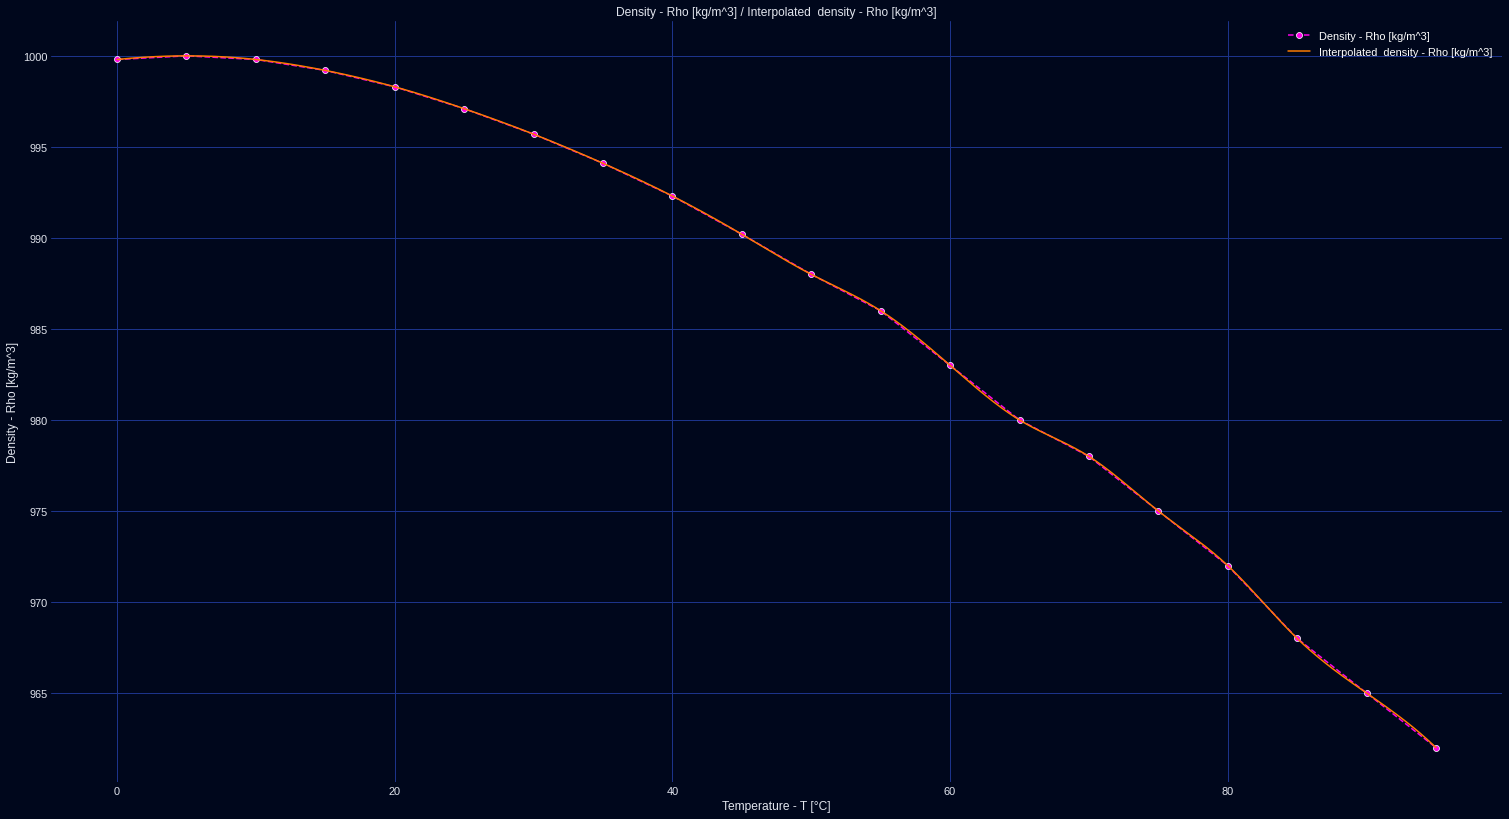

<Figure size 1872x1008 with 0 Axes>

In [420]:
water_rho = np.array(water[rho_col])                                                                    # Water density array (thermophysic variable vs temp)
f_water_rho = interp1d(water_temp, water_rho, kind=water_intp_typ)                                      # Water density interpolation function (thermophysic variable vs temp)

plot_tp_vars(water_temp, water_rho, f_water_rho, water_intp_pts, plt_temp_lbl,
             plt_rho_lbl, plt_intp_rho_lbl, plt_rho_lbl+plt_title_sep+plt_intp_rho_lbl)                 # Function call to plot water density and interpolation (thermophysic variable vs temp)

* Function definition to apply water specific heat at constant pressure interpolation

TypeError: expected x and y to have same length

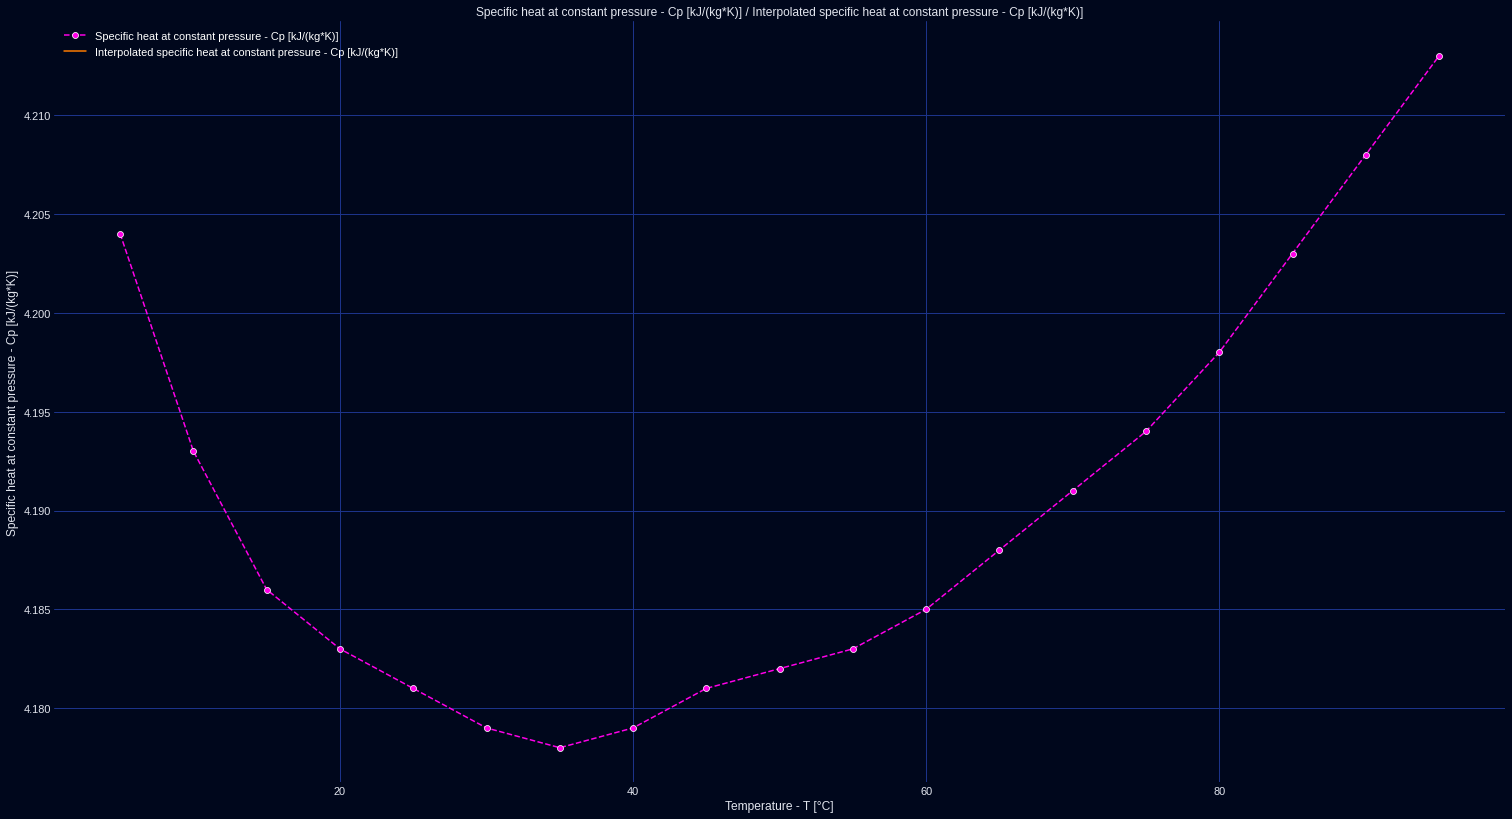

<Figure size 1872x1008 with 0 Axes>

In [445]:
water_cp = np.array(water[cp_col])                                                                      # Water specific heat at constant pressure array (thermophysic variable vs temp)
f_water_cp = interp1d(water_temp, water_cp, kind=water_intp_typ)                                        # Water specific heat at constant pressure interpolation function (thermophysic variable vs temp)

plot_tp_vars(water_temp, water_cp, f_water_cp, water_intp_pts, plt_temp_lbl,
             plt_cp_lbl, plt_intp_cp_lbl, plt_cp_lbl+plt_title_sep+plt_intp_cp_lbl)                     # Function call to plot water specific heat at constant pressure and interpolation (thermophysic variable vs temp)

p = np.polyfit(air_atmp_temp, water_cp, 2)
xx = np.linspace(-150, 400, 1000)
yy = np.polyval(p, xx)
plt.plot(xx, yy, "--")
plt.plot(air_atmp_temp, water_cp, 'o')

* Function definition to apply water thermal conductivity interpolation

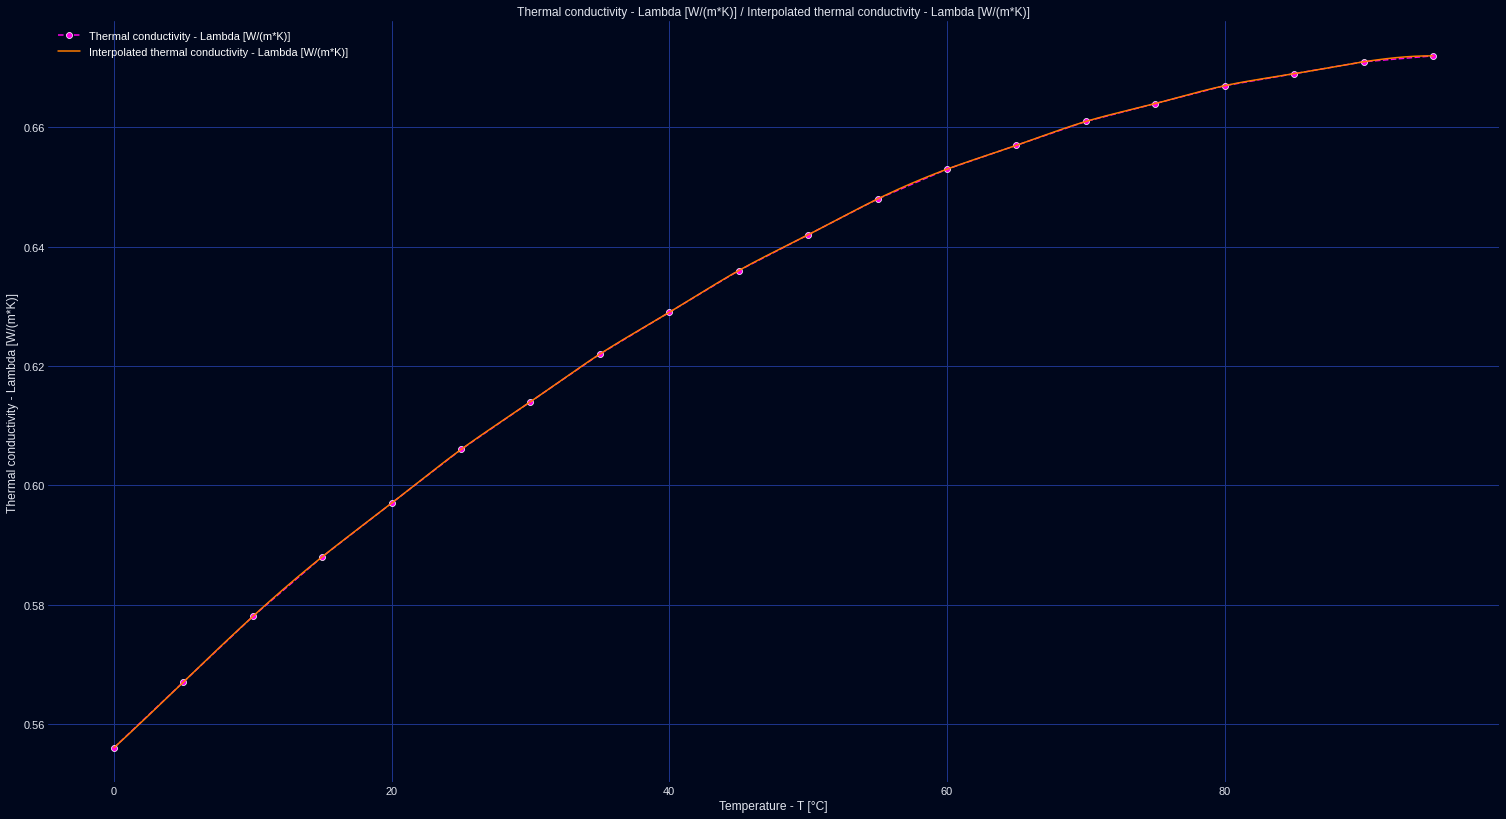

<Figure size 1872x1008 with 0 Axes>

In [422]:
water_lambda = np.array(water[lambda_col])                                                              # Water thermal conductivity array (thermophysic variable vs temp)
f_water_lambda = interp1d(water_temp, water_lambda, kind=water_intp_typ)                                # Water thermal conductivity interpolation function (thermophysic variable vs temp)

plot_tp_vars(water_temp, water_lambda, f_water_lambda, water_intp_pts, plt_temp_lbl,
             plt_lambda_lbl, plt_intp_lambda_lbl, plt_lambda_lbl+plt_title_sep+plt_intp_lambda_lbl)     # Function call to plot water thermal conductivity and interpolation (thermophysic variable vs temp)

* Function definition to apply water kinematic viscosity interpolation

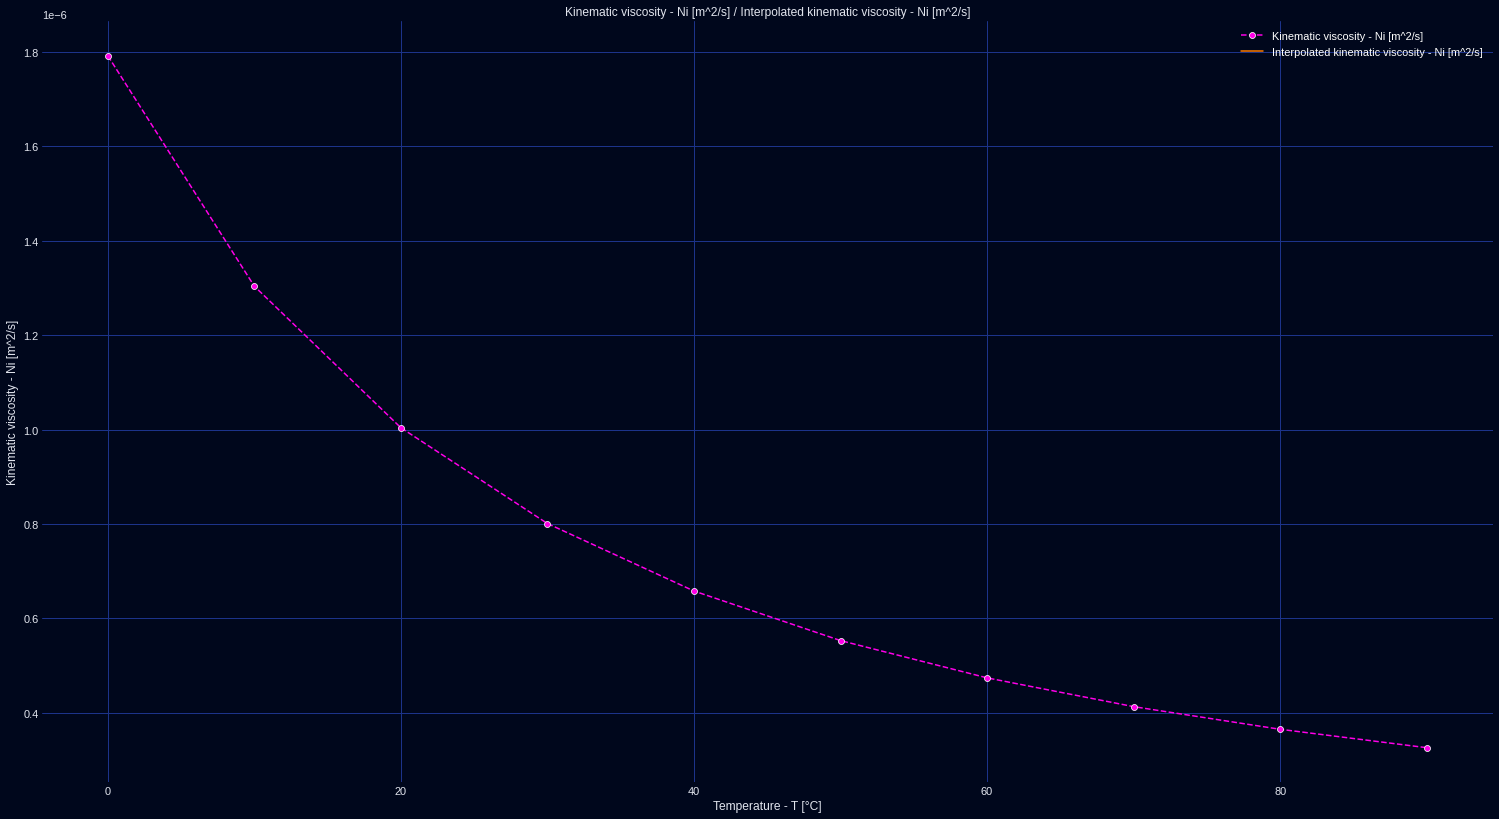

<Figure size 1872x1008 with 0 Axes>

In [423]:
water_ni = np.array(water[ni_col])                                                                      # Water kinematic viscosity array (thermophysic variable vs temp)
f_water_ni = interp1d(water_temp, water_ni, kind=water_intp_typ)                                        # Water kinematic viscosity interpolation function (thermophysic variable vs temp)

plot_tp_vars(water_temp, water_ni, f_water_ni, water_intp_pts, plt_temp_lbl,
             plt_ni_lbl, plt_intp_ni_lbl, plt_ni_lbl+plt_title_sep+plt_intp_ni_lbl)                     # Function call to plot water kinematic viscosity and interpolation (thermophysic variable vs temp)

* Function definition to apply water thermodynamic beta (Coldness) interpolation

TypeError: expected x and y to have same length

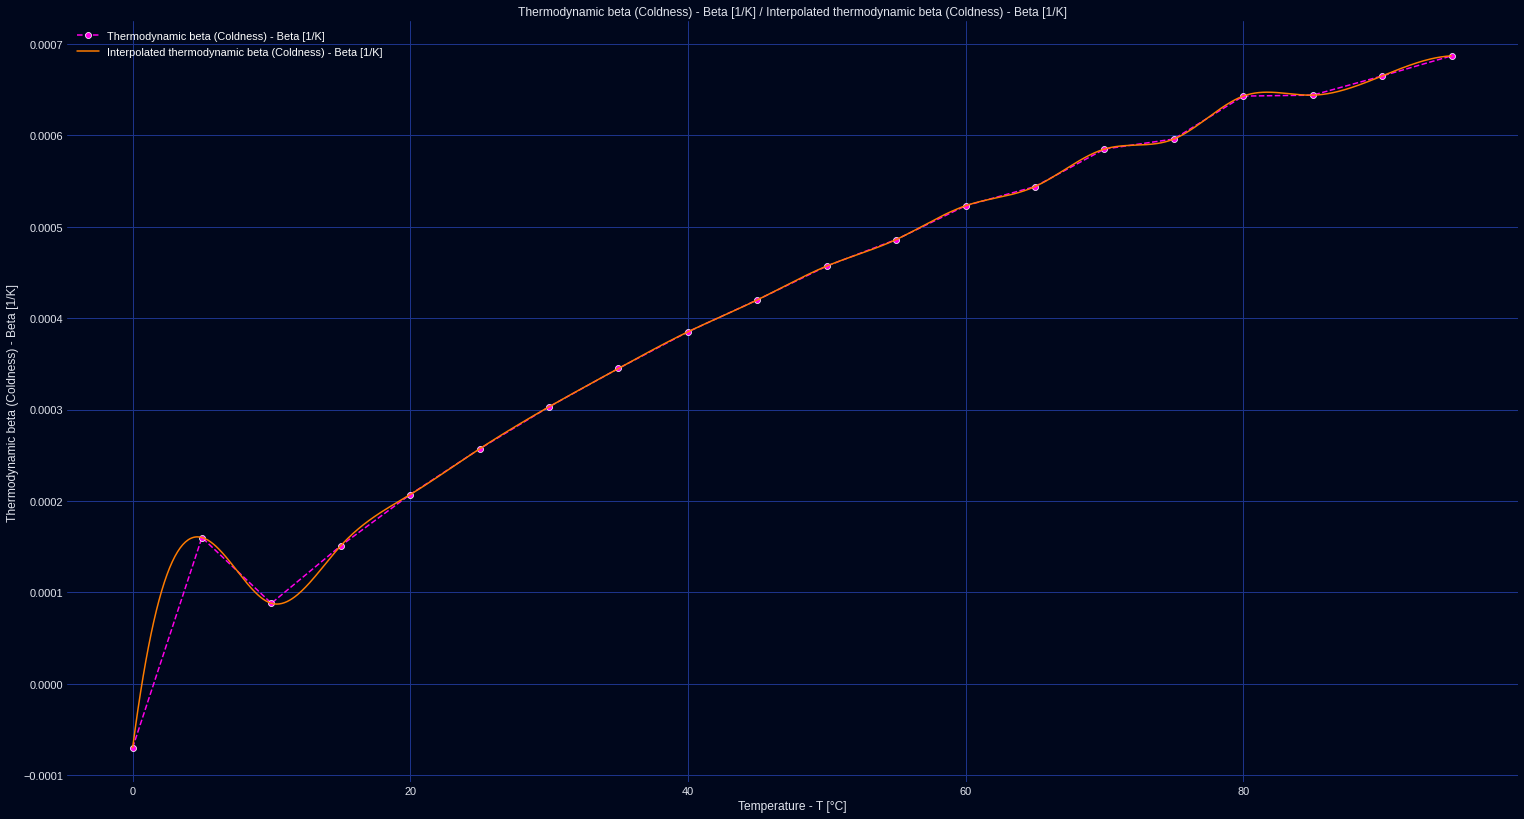

<Figure size 1872x1008 with 0 Axes>

In [446]:
water_beta = np.array(water[beta_col])                                                                  # Water thermodynamic beta (Coldness) array (thermophysic variable vs temp)
f_water_beta = interp1d(water_temp, water_beta, kind=water_intp_typ)                                    # Water thermodynamic beta (Coldness) interpolation function (thermophysic variable vs temp)

plot_tp_vars(water_temp, water_beta, f_water_beta, water_intp_pts, plt_temp_lbl,
             plt_beta_lbl, plt_intp_beta_lbl, plt_beta_lbl+plt_title_sep+plt_intp_beta_lbl)             # Function call to plot water thermodynamic beta (Coldness) and interpolation (thermophysic variable vs temp)

p = np.polyfit(air_atmp_temp, water_beta, 2)
xx = np.linspace(-150, 400, 1000)
yy = np.polyval(p, xx)
plt.plot(xx, yy, "--")
plt.plot(air_atmp_temp, water_beta, 'o')

* Function definition to apply water Prandtl number interpolation

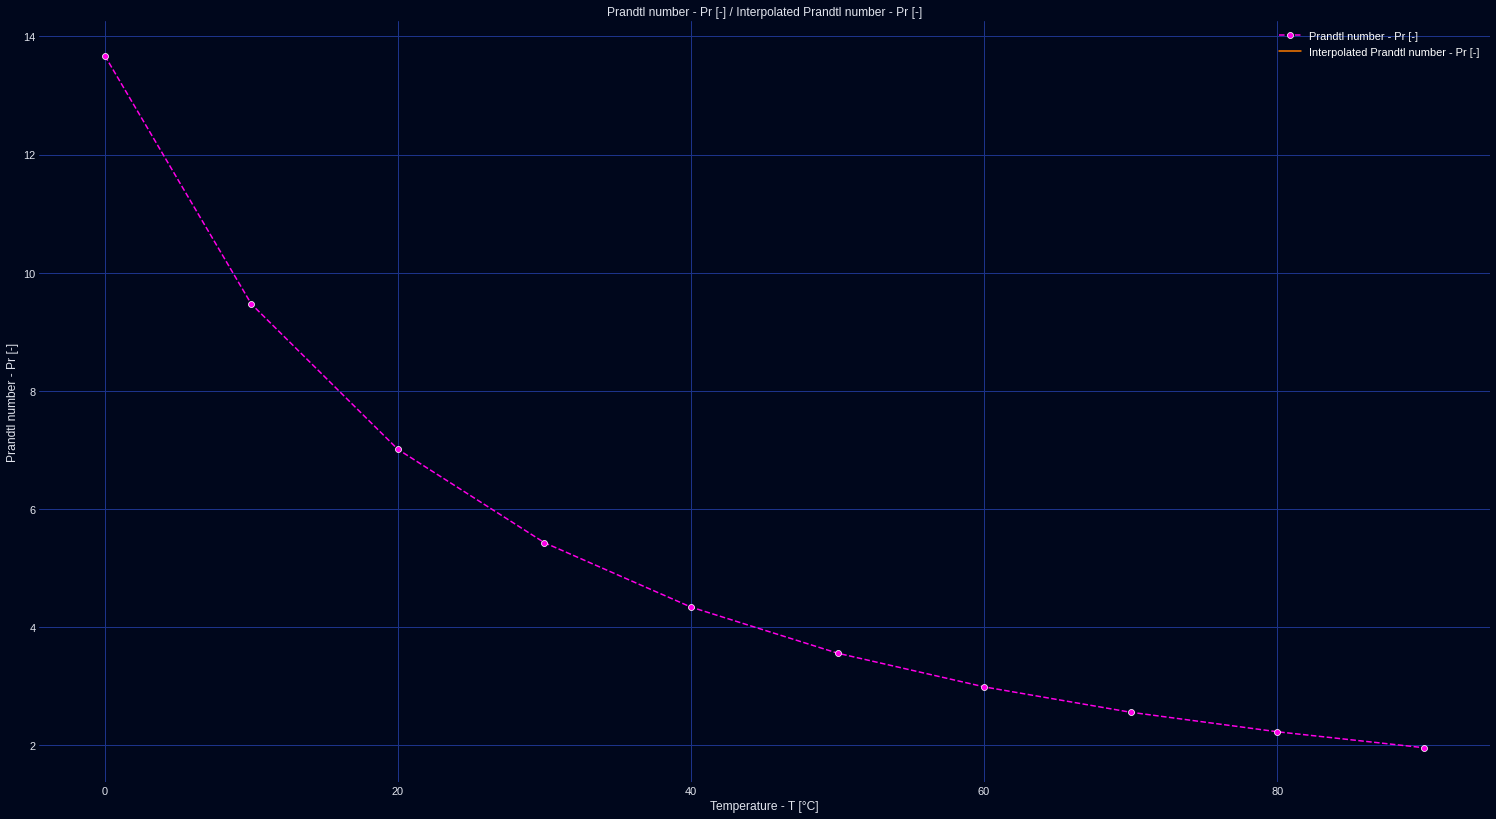

<Figure size 1872x1008 with 0 Axes>

In [425]:
water_pr = np.array(water[pr_col])                                                                      # Water Prandtl number array (thermophysic variable vs temp)
f_water_pr = interp1d(water_temp, water_pr, kind=water_intp_typ)                                        # Water Prandtl number interpolation function (thermophysic variable vs temp)

plot_tp_vars(water_temp, water_pr, f_water_pr, water_intp_pts, plt_temp_lbl,
             plt_pr_lbl, plt_intp_pr_lbl, plt_pr_lbl+plt_title_sep+plt_intp_pr_lbl)                     # Function call to plot water Prandtl number and interpolation (thermophysic variable vs temp)

## Engineering calcs

### - TD vars

* Ajkdbsckcjdb

In [426]:
                                                                                                        # -